In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset

import time
import collections
from tqdm import tqdm_notebook as tqdm
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
class MixtureSameFamily(D.Distribution):
    def __init__(self, mixture, components):
        self.mixture = mixture
        self.components = components
        self._num_components = len(components)
        self._event_ndims = len(components[0].event_shape)
        super().__init__(batch_shape=components[0].batch_shape[:-1], event_shape=components[0].event_shape)
        
    def sample(self, sample_shape=torch.Size()):
        with torch.no_grad():
            mix_sample = self.mixture.sample(sample_shape)
            comp_sample = torch.stack([comp.sample(sample_shape)[0] if isinstance(comp, MixtureSameFamily) else comp.sample(sample_shape) for comp in self.components], dim=1)
            mask = F.one_hot(mix_sample, self._num_components)
            mask = self._pad_mixture_dimensions(mask)
            comp_sample = torch.sum(comp_sample * mask.to(comp_sample.dtype), dim=-1 - self._event_ndims)
            return comp_sample, mix_sample
    
    def log_prob_comp(self, x):
        d = len(x.shape) - self._event_ndims
        x = x.reshape(*x.shape[:d], 1, *x.shape[d:])
        log_prob_x = torch.cat([comp.log_prob(x) for comp in self.components], dim=-1)
        log_mix_prob = torch.log_softmax(self.mixture.logits, dim=-1)
        return log_prob_x + log_mix_prob
        
    def log_prob(self, x):
        return torch.logsumexp(self.log_prob_comp(x), dim=-1)
    
    def cond_prob(self, x):
        prob_comp = self.log_prob_comp(x).exp()
        return prob_comp / prob_comp.sum(dim=-1, keepdims=True)
    
    def _pad_mixture_dimensions(self, x):
        dist_batch_ndims = self.batch_shape.numel()
        cat_batch_ndims = self.mixture.batch_shape.numel()
        pad_ndims = 0 if cat_batch_ndims == 1 else dist_batch_ndims - cat_batch_ndims
        x = torch.reshape(x, shape=(*x.shape[:-1], *(pad_ndims*[1]), *x.shape[-1:], *(self._event_ndims*[1])))
        return x

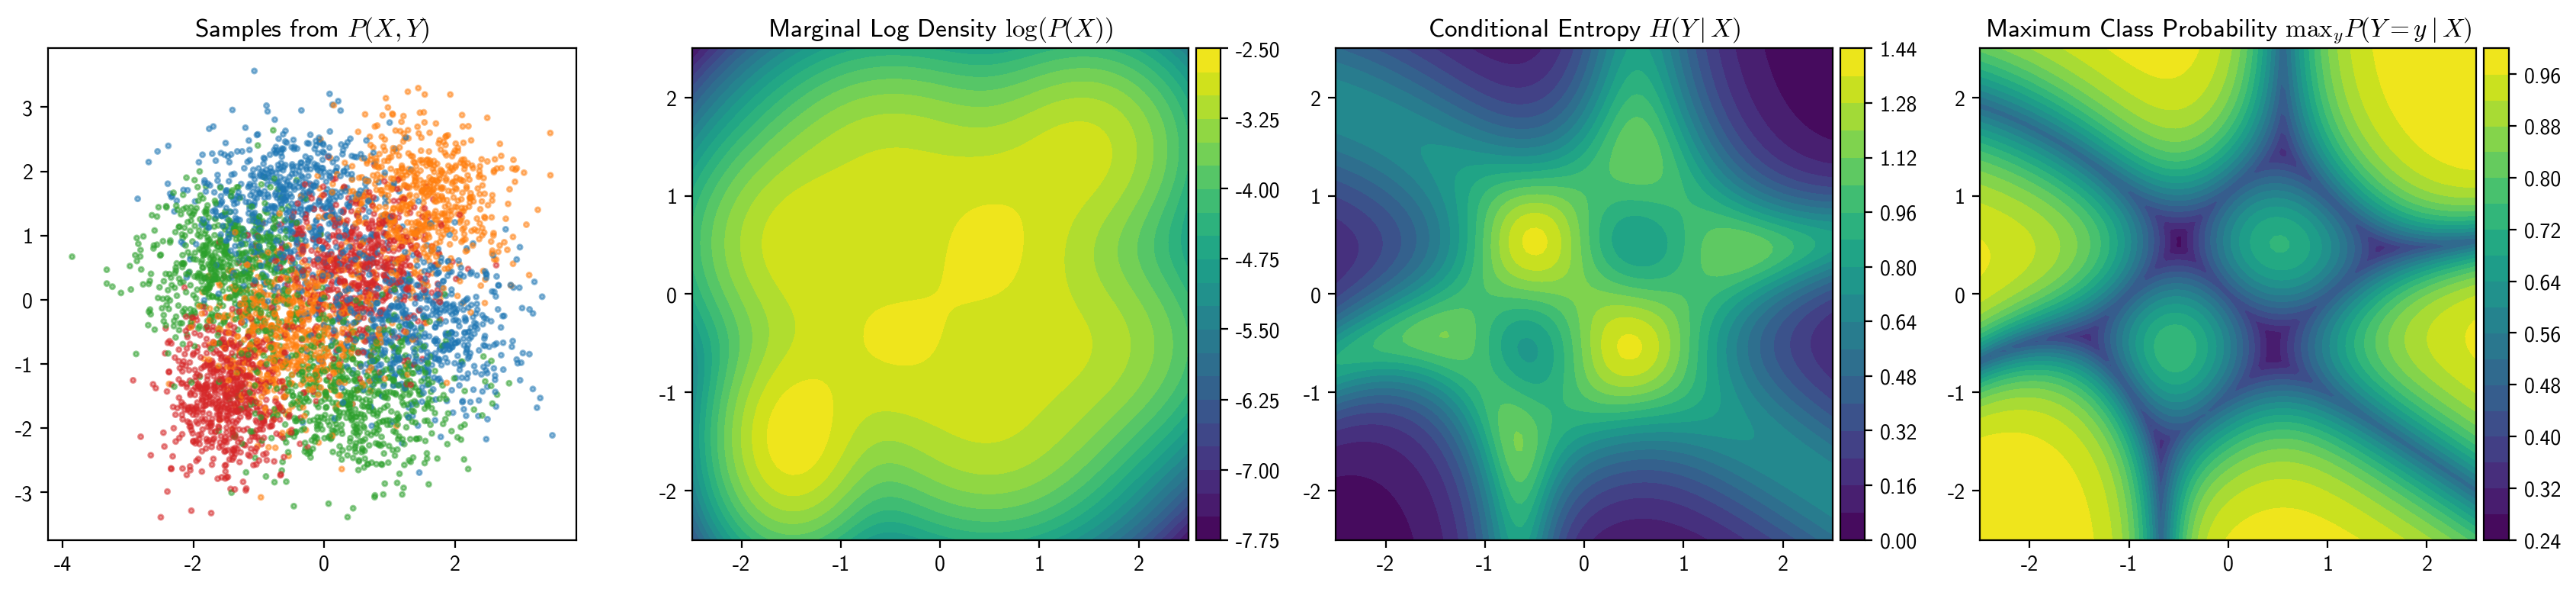

In [6]:
torch.manual_seed(0)
mus = [torch.tensor([(-0.5, 1.5), (1.5, -0.5)]), torch.tensor([(-0.5, -0.5), (1.5, 1.5)]), torch.tensor([(-1.5, 0.5), (0.5, -1.5)]), torch.tensor([(-1.5, -1.5), (0.5, 0.5)])]
gmm = MixtureSameFamily(D.Categorical(torch.ones(4)), [MixtureSameFamily(D.Categorical(torch.ones(2)), [D.MultivariateNormal(m, 0.2 * torch.tensor([[1.0 * torch.randint(1, 4, (1,)), 0.], [0, 1.0 * torch.randint(2, 3, (1,))]])) for i, m in enumerate(mu)]) for mu in mus])
X, Y = torch.meshgrid(torch.linspace(-2.5, 2.5, 100), torch.linspace(-2.5, 2.5, 100))
grid = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=-1)
samples, labels = gmm.sample((5000,))

fig, [ax0, ax1, ax2, ax3] = plt.subplots(1, 4, figsize=(17, 4))
ax0.set_title('Samples from $P(X, Y)$')
img0 = ax0.scatter(samples[:, 0], samples[:, 1], c=['C{}'.format(label) for label in labels], s=5, alpha=0.5)

ax1.set_title('Marginal Log Density $\log(P(X))$')
img1 = ax1.contourf(X, Y, gmm.log_prob(grid).view(100, 100), levels=20)

ax2.set_title('Conditional Entropy $H(Y \mid X)$')
img2 = ax2.contourf(X, Y, -(gmm.cond_prob(grid) * gmm.cond_prob(grid).log()).sum(dim=-1).view(100, 100), levels=20)

ax3.set_title(r'Maximum Class Probability $\mathrm{max}_y P(Y = y \mid X)$')
img3 = ax3.contourf(X, Y, gmm.cond_prob(grid).max(dim=1)[0].view(100, 100), levels=20);

for img, ax in [(img1, ax1), (img2, ax2), (img3, ax3)]:
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')
plt.tight_layout()

### Standard Softmax Classification

In [29]:
model = nn.Sequential(nn.Linear(2, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 4)).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)
train_loader = DataLoader(TensorDataset(*gmm.sample((3000,))), batch_size=100, shuffle=True)
valid_loader = DataLoader(TensorDataset(*gmm.sample((3000,))), batch_size=100, shuffle=True)

std_hist = collections.defaultdict(list)
for epoch in range(50):
    model.train()
    train_loss, train_acc, train_prob_pos, train_prob_neg = 0., 0., 0., 0.
    for batch_idx, (samples, labels) in enumerate(train_loader):
        samples, labels = samples.cuda(), labels.cuda()
        logits = model(samples)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = logits.argmax(dim=1)
        mask = preds.eq(labels)
        train_acc += mask.sum().item()
        max_probs = torch.gather(F.softmax(logits, dim=-1), dim=-1, index=preds.unsqueeze(-1))
        train_prob_pos += max_probs[mask].sum().item()
        train_prob_neg += max_probs[~mask].sum().item()
        
    model.eval()
    valid_loss, valid_acc, valid_prob_pos, valid_prob_neg = 0., 0., 0., 0.
    for batch_idx, (samples, labels) in enumerate(valid_loader):
        samples, labels = samples.cuda(), labels.cuda()
        logits = model(samples)
        loss = F.cross_entropy(logits, labels)
        valid_loss += loss.item()
        
        preds = logits.argmax(dim=1)
        mask = preds.eq(labels)
        valid_acc += mask.sum().item()
        max_probs = torch.gather(F.softmax(logits, dim=-1), dim=-1, index=preds.unsqueeze(-1))
        valid_prob_pos += max_probs[mask].sum().item()
        valid_prob_neg += max_probs[~mask].sum().item()
        
    std_hist['train_loss'].append(train_loss / len(train_loader))
    std_hist['train_acc'].append(train_acc / len(train_loader.dataset))
    std_hist['train_prob_pos'].append(train_prob_pos / (train_acc + 1e-6))
    std_hist['train_prob_neg'].append(train_prob_neg / (len(train_loader.dataset) - train_acc))
    
    std_hist['valid_loss'].append(valid_loss / len(valid_loader))
    std_hist['valid_acc'].append(valid_acc / len(valid_loader.dataset))
    std_hist['valid_prob_pos'].append(valid_prob_pos / (valid_acc + 1e-6))
    std_hist['valid_prob_neg'].append(valid_prob_neg / (len(valid_loader.dataset) - valid_acc))
        
    print('Epoch {:02d}: train_loss {:.3f}, train_acc {:.3f}, train_pos {:.3f}, train_neg {:.3f}, valid_loss {:.3f}, valid_acc {:.3f}, valid_pos {:.3f}, valid_neg {:.3f}'.format(
        epoch, std_hist['train_loss'][-1], std_hist['train_acc'][-1], std_hist['train_prob_pos'][-1], std_hist['train_prob_neg'][-1], std_hist['valid_loss'][-1], std_hist['valid_acc'][-1],
        std_hist['valid_prob_pos'][-1], std_hist['valid_prob_neg'][-1],
    ))

Epoch 00: train_loss 1.253, train_acc 0.490, train_pos 0.347, train_neg 0.301, valid_loss 1.134, valid_acc 0.594, valid_pos 0.407, valid_neg 0.341
Epoch 01: train_loss 1.065, train_acc 0.602, train_pos 0.464, train_neg 0.376, valid_loss 1.010, valid_acc 0.608, valid_pos 0.507, valid_neg 0.396
Epoch 02: train_loss 0.961, train_acc 0.616, train_pos 0.543, train_neg 0.421, valid_loss 0.929, valid_acc 0.612, valid_pos 0.574, valid_neg 0.432
Epoch 03: train_loss 0.895, train_acc 0.623, train_pos 0.598, train_neg 0.454, valid_loss 0.879, valid_acc 0.617, valid_pos 0.617, valid_neg 0.451
Epoch 04: train_loss 0.860, train_acc 0.627, train_pos 0.633, train_neg 0.474, valid_loss 0.850, valid_acc 0.625, valid_pos 0.644, valid_neg 0.468
Epoch 05: train_loss 0.834, train_acc 0.637, train_pos 0.654, train_neg 0.492, valid_loss 0.831, valid_acc 0.647, valid_pos 0.648, valid_neg 0.482
Epoch 06: train_loss 0.820, train_acc 0.652, train_pos 0.661, train_neg 0.507, valid_loss 0.818, valid_acc 0.658, vali

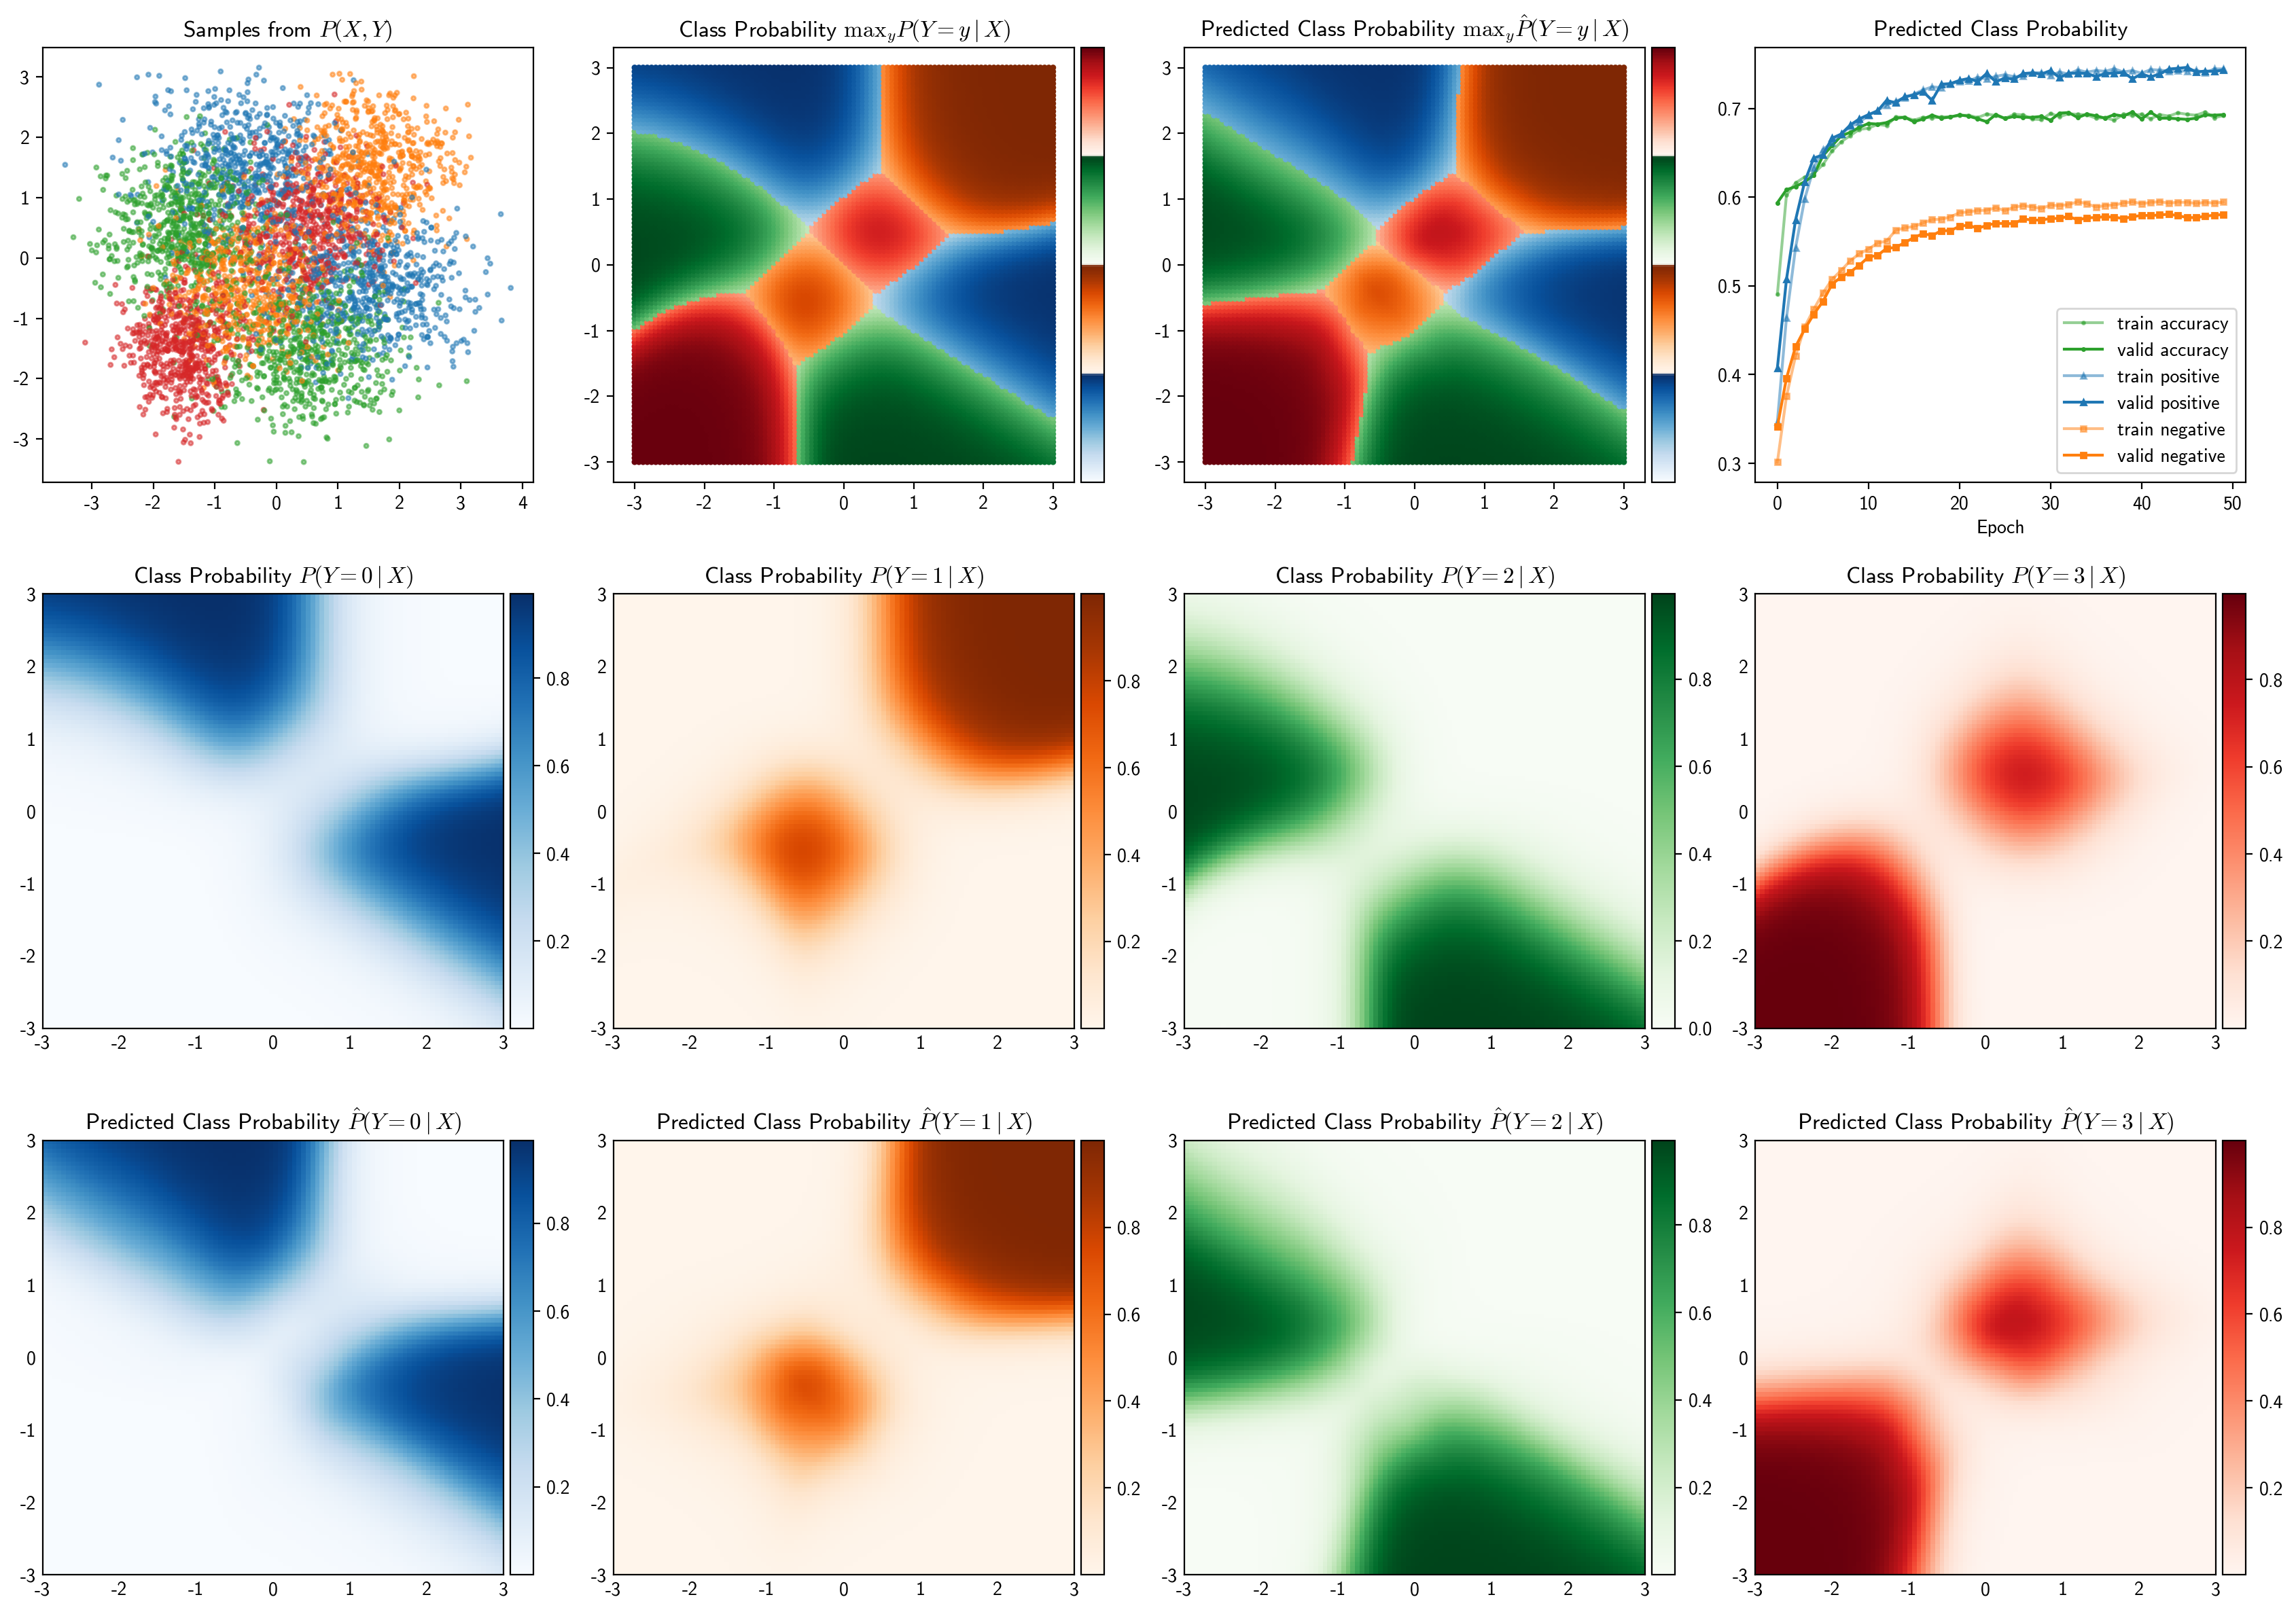

In [30]:
X, Y = torch.meshgrid(torch.linspace(-3, 3, 100), torch.linspace(-3, 3, 100))
grid = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=-1)
samples, labels = gmm.sample((5000,))

fig, axes = plt.subplots(3, 4, figsize=(17, 12))
axes[0][0].set_title('Samples from $P(X, Y)$')
img0 = axes[0][0].scatter(samples[:, 0], samples[:, 1], c=['C{}'.format(label) for label in labels], s=5, alpha=0.5)

axes[0][1].set_title(r'Class Probability $\mathrm{max}_y P(Y = y \mid X)$')
max_probs, max_labels = gmm.cond_prob(grid).max(dim=1)
colormaps = [plt.get_cmap(color) for color in ['Blues', 'Oranges', 'Greens', 'Reds']]
img1 = axes[0][1].scatter(grid[:, 0], grid[:, 1], c=[colormaps[label](prob) for prob, label in zip(max_probs, max_labels)], s=5)
cmap = mpl.colors.LinearSegmentedColormap.from_list(None, np.vstack([plt.get_cmap(color)(np.linspace(0, 1, 50)) for color in ['Blues', 'Oranges', 'Greens', 'Reds']]))
cbar = mpl.colorbar.ColorbarBase(make_axes_locatable(axes[0][1]).append_axes('right', size='5%', pad=0.05), cmap=cmap, orientation = 'vertical')
cbar.set_ticks([])

axes[0][2].set_title(r'Predicted Class Probability $\mathrm{max}_y \hat{P}(Y = y \mid X)$')
probs = F.softmax(model(grid.cuda()), dim=-1)
max_probs, preds = probs.max(axis=1)
axes[0][2].scatter(grid[:, 0], grid[:, 1], c=[colormaps[pred](prob) for prob, pred in zip(max_probs.detach().cpu(), preds.detach().cpu())], s=5)
cbar = mpl.colorbar.ColorbarBase(make_axes_locatable(axes[0][2]).append_axes('right', size='5%', pad=0.05), cmap=cmap, orientation = 'vertical')
cbar.set_ticks([])

axes[0][3].set_title('Predicted Class Probability')
axes[0][3].plot(range(len(std_hist['train_acc'])), std_hist['train_acc'], marker='.', c='C2', label='train accuracy', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(std_hist['valid_acc'])), std_hist['valid_acc'], marker='.', c='C2', label='valid accuracy', markersize=3)
axes[0][3].plot(range(len(std_hist['train_prob_pos'])), std_hist['train_prob_pos'], marker='^', c='C0', label='train positive', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(std_hist['valid_prob_pos'])), std_hist['valid_prob_pos'], marker='^', c='C0', label='valid positive', markersize=3)
axes[0][3].plot(range(len(std_hist['train_prob_neg'])), std_hist['train_prob_neg'], marker='s', c='C1', label='train negative', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(std_hist['valid_prob_neg'])), std_hist['valid_prob_neg'], marker='s', c='C1', label='valid negative', markersize=3)
axes[0][3].set_xlabel('Epoch')
axes[0][3].legend();

for class_idx in range(4):
    axes[1][class_idx].set_title('Class Probability $P(Y = {} \mid X)$'.format(class_idx))
    img = axes[1][class_idx].imshow(gmm.cond_prob(grid)[:, class_idx].view(100, 100).detach().cpu().numpy().transpose(), cmap=colormaps[class_idx], origin='lower', aspect='auto', extent=[-3, 3, -3, 3],)
    axes[1][class_idx].tick_params(axis='both', which='both', length=0)
    plt.colorbar(img, cax=make_axes_locatable(axes[1][class_idx]).append_axes('right', size='5%', pad=0.05), orientation='vertical')  
    
    axes[2][class_idx].set_title('Predicted Class Probability $\hat{{P}}(Y = {} \mid X)$'.format(class_idx))
    img = axes[2][class_idx].imshow(probs[:, class_idx].view(100, 100).detach().cpu().numpy().transpose(), cmap=colormaps[class_idx], origin='lower', aspect='auto', extent=[-3, 3, -3, 3],)
    axes[2][class_idx].tick_params(axis='both', which='both', length=0)
    plt.colorbar(img, cax=make_axes_locatable(axes[2][class_idx]).append_axes('right', size='5%', pad=0.05), orientation='vertical')  
plt.tight_layout()

### Confidence Network (DeVries & Taylor, 2018)

In [104]:
class ConfidenceNetwork(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.trunk = nn.Sequential(nn.Linear(2, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.head1 = nn.Linear(hidden_dim, 4)
        self.head2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out = self.trunk(x)
        probs = F.softmax(self.head1(out), dim=-1)
        conf = torch.sigmoid(self.head2(out))
        return probs, conf

model = ConfidenceNetwork().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)
train_loader = DataLoader(TensorDataset(*gmm.sample((3000,))), batch_size=100, shuffle=True)
valid_loader = DataLoader(TensorDataset(*gmm.sample((3000,))), batch_size=100, shuffle=True)

conf_hist = collections.defaultdict(list)
for epoch in range(50):
    model.train()
    train_loss, train_loss1, train_loss2, train_acc, train_conf_pos, train_conf_neg = 0., 0, 0., 0., 0., 0.
    for batch_idx, (samples, labels) in enumerate(train_loader):
        samples, labels = samples.cuda(), labels.cuda()
        probs, confidence = model(samples)
        mask = torch.randint_like(probs, low=0, high=2)
        conf = confidence * mask + (1 - mask)
        scores = conf * probs + (1 - conf) * F.one_hot(labels)
        loss1 = F.nll_loss((scores + 1e-12).log(), labels)
        loss2 = -0.1 * (conf + 1e-12).log().mean()
        loss = loss1 + loss2
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()

        preds = probs.argmax(dim=1)
        mask = preds.eq(labels)
        train_acc += mask.sum().item()
        train_conf_pos += confidence[mask].sum().item()
        train_conf_neg += confidence[~mask].sum().item()
        
    model.eval()
    valid_loss, valid_acc, valid_conf_pos, valid_conf_neg = 0., 0., 0., 0.
    for batch_idx, (samples, labels) in enumerate(valid_loader):
        samples, labels = samples.cuda(), labels.cuda()
        probs, confidence = model(samples)
        mask = torch.randint_like(probs, low=0, high=2)
        conf = confidence * mask + (1 - mask)
        scores = conf * probs + (1 - conf) * F.one_hot(labels)
        loss1 = F.nll_loss((scores + 1e-12).log(), labels)
        loss2 = -0.1 * (conf + 1e-12).log().mean()
        loss = loss1 + loss2
        valid_loss += loss.item()
        
        preds = probs.argmax(dim=1)
        mask = preds.eq(labels)
        valid_acc += mask.sum().item()
        valid_conf_pos += confidence[mask].sum().item()
        valid_conf_neg += confidence[~mask].sum().item()
        
    conf_hist['train_loss'].append(train_loss / len(train_loader))
    conf_hist['train_loss1'].append(train_loss1 / len(train_loader))
    conf_hist['train_loss2'].append(train_loss2 / len(train_loader))
    conf_hist['train_acc'].append(train_acc / len(train_loader.dataset))
    conf_hist['train_conf_pos'].append(train_conf_pos / (train_acc + 1e-6))
    conf_hist['train_conf_neg'].append(train_conf_neg / (len(train_loader.dataset) - train_acc))
    
    conf_hist['valid_loss'].append(valid_loss / len(valid_loader))
    conf_hist['valid_acc'].append(valid_acc / len(valid_loader.dataset))
    conf_hist['valid_conf_pos'].append(valid_conf_pos / (valid_acc + 1e-6))
    conf_hist['valid_conf_neg'].append(valid_conf_neg / (len(valid_loader.dataset) - valid_acc))
        
    print('Epoch {:02d}: train_loss {:.3f} (nll {:.3f} | conf {:.3f}), train_acc {:.3f}, train_pos {:.3f}, train_neg {:.3f}, valid_loss {:.3f}, valid_acc {:.3f}, valid_pos {:.3f}, valid_neg {:.3f}'.format(
        epoch, conf_hist['train_loss'][-1], conf_hist['train_loss1'][-1], conf_hist['train_loss2'][-1], conf_hist['train_acc'][-1], conf_hist['train_conf_pos'][-1], conf_hist['train_conf_neg'][-1], conf_hist['valid_loss'][-1], conf_hist['valid_acc'][-1],
        conf_hist['valid_conf_pos'][-1], conf_hist['valid_conf_neg'][-1],
    ))

Epoch 00: train_loss 0.929 (nll 0.889 | conf 0.040), train_acc 0.431, train_pos 0.442, train_neg 0.458, valid_loss 0.877, valid_acc 0.524, valid_pos 0.367, valid_neg 0.384
Epoch 01: train_loss 0.819 (nll 0.758 | conf 0.061), train_acc 0.555, train_pos 0.294, train_neg 0.318, valid_loss 0.797, valid_acc 0.575, valid_pos 0.221, valid_neg 0.251
Epoch 02: train_loss 0.758 (nll 0.676 | conf 0.082), train_acc 0.557, train_pos 0.181, train_neg 0.212, valid_loss 0.741, valid_acc 0.590, valid_pos 0.153, valid_neg 0.186
Epoch 03: train_loss 0.705 (nll 0.609 | conf 0.096), train_acc 0.603, train_pos 0.140, train_neg 0.175, valid_loss 0.687, valid_acc 0.599, valid_pos 0.134, valid_neg 0.167
Epoch 04: train_loss 0.684 (nll 0.588 | conf 0.096), train_acc 0.596, train_pos 0.130, train_neg 0.166, valid_loss 0.649, valid_acc 0.620, valid_pos 0.131, valid_neg 0.165
Epoch 05: train_loss 0.644 (nll 0.546 | conf 0.098), train_acc 0.608, train_pos 0.133, train_neg 0.168, valid_loss 0.629, valid_acc 0.608, v

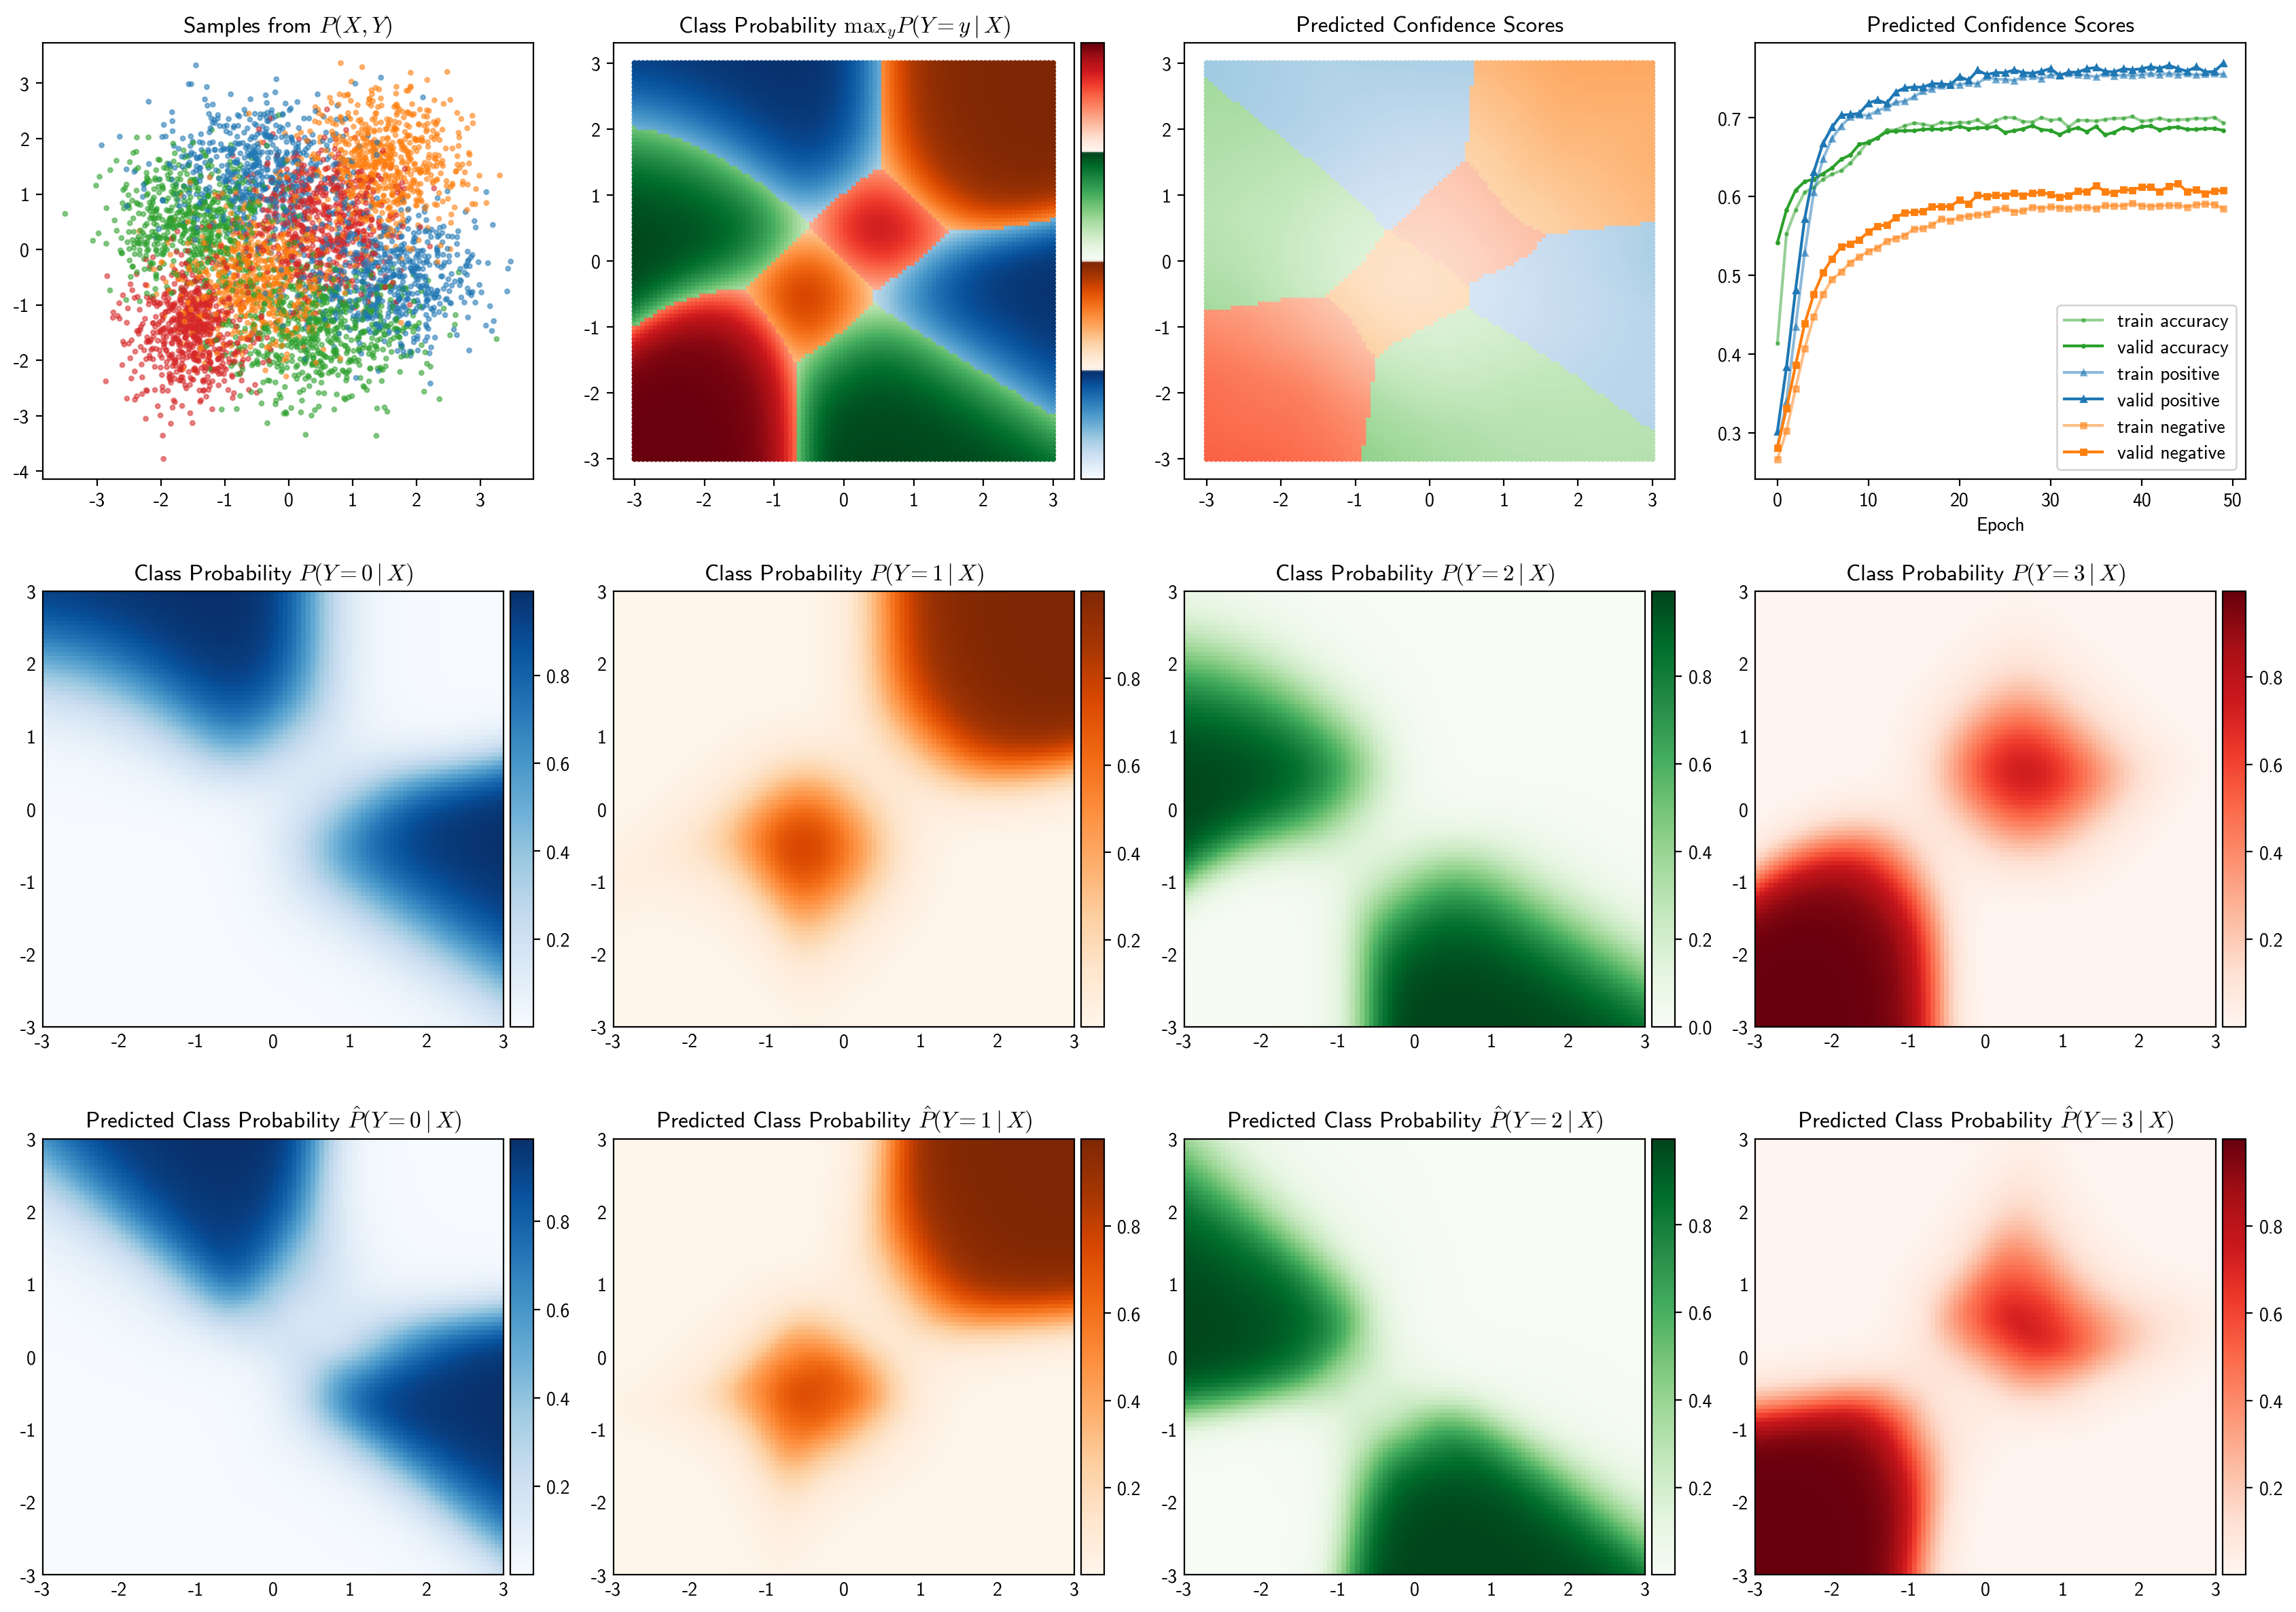

In [106]:
X, Y = torch.meshgrid(torch.linspace(-3, 3, 100), torch.linspace(-3, 3, 100))
grid = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=-1)
samples, labels = gmm.sample((5000,))

fig, axes = plt.subplots(3, 4, figsize=(17, 12))
axes[0][0].set_title('Samples from $P(X, Y)$')
img0 = axes[0][0].scatter(samples[:, 0], samples[:, 1], c=['C{}'.format(label) for label in labels], s=5, alpha=0.5)

axes[0][1].set_title(r'Class Probability $\mathrm{max}_y P(Y = y \mid X)$')
max_probs, max_labels = gmm.cond_prob(grid).max(dim=1)
colormaps = [plt.get_cmap(color) for color in ['Blues', 'Oranges', 'Greens', 'Reds']]
img1 = axes[0][1].scatter(grid[:, 0], grid[:, 1], c=[colormaps[label](prob) for prob, label in zip(max_probs, max_labels)], s=5)
cmap = mpl.colors.LinearSegmentedColormap.from_list(None, np.vstack([plt.get_cmap(color)(np.linspace(0, 1, 50)) for color in ['Blues', 'Oranges', 'Greens', 'Reds']]))
cbar = mpl.colorbar.ColorbarBase(make_axes_locatable(axes[0][1]).append_axes('right', size='5%', pad=0.05), cmap=cmap, orientation = 'vertical')
cbar.set_ticks([])

axes[0][2].set_title(r'Predicted Confidence Scores')
probs, confidence = model(grid.cuda())
max_probs, preds = probs.max(axis=1)
axes[0][2].scatter(grid[:, 0], grid[:, 1], c=[colormaps[pred](conf) for conf, pred in zip(confidence.squeeze().detach().cpu(), preds.detach().cpu())], s=5)
cbar = mpl.colorbar.ColorbarBase(make_axes_locatable(ax2).append_axes('right', size='5%', pad=0.05), cmap=cmap, orientation = 'vertical')
cbar.set_ticks([])

axes[0][3].set_title('Predicted Confidence Scores')
axes[0][3].plot(range(len(std_hist['train_acc'])), std_hist['train_acc'], marker='.', c='C2', label='train accuracy', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(std_hist['valid_acc'])), std_hist['valid_acc'], marker='.', c='C2', label='valid accuracy', markersize=3)
axes[0][3].plot(range(len(std_hist['train_prob_pos'])), std_hist['train_prob_pos'], marker='^', c='C0', label='train positive', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(std_hist['valid_prob_pos'])), std_hist['valid_prob_pos'], marker='^', c='C0', label='valid positive', markersize=3)
axes[0][3].plot(range(len(std_hist['train_prob_neg'])), std_hist['train_prob_neg'], marker='s', c='C1', label='train negative', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(std_hist['valid_prob_neg'])), std_hist['valid_prob_neg'], marker='s', c='C1', label='valid negative', markersize=3)
axes[0][3].set_xlabel('Epoch')
axes[0][3].legend();

for class_idx in range(4):
    axes[1][class_idx].set_title('Class Probability $P(Y = {} \mid X)$'.format(class_idx))
    img = axes[1][class_idx].imshow(gmm.cond_prob(grid)[:, class_idx].view(100, 100).detach().cpu().numpy().transpose(), cmap=colormaps[class_idx], origin='lower', aspect='auto', extent=[-3, 3, -3, 3],)
    axes[1][class_idx].tick_params(axis='both', which='both', length=0)
    plt.colorbar(img, cax=make_axes_locatable(axes[1][class_idx]).append_axes('right', size='5%', pad=0.05), orientation='vertical')  
    
    axes[2][class_idx].set_title('Predicted Class Probability $\hat{{P}}(Y = {} \mid X)$'.format(class_idx))
    img = axes[2][class_idx].imshow(probs[:, class_idx].view(100, 100).detach().cpu().numpy().transpose(), cmap=colormaps[class_idx], origin='lower', aspect='auto', extent=[-3, 3, -3, 3],)
    axes[2][class_idx].tick_params(axis='both', which='both', length=0)
    plt.colorbar(img, cax=make_axes_locatable(axes[2][class_idx]).append_axes('right', size='5%', pad=0.05), orientation='vertical')  
plt.tight_layout()

### Data Augmentation

In [147]:
model = nn.Sequential(nn.Linear(2, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 5)).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)
noise_dist = D.StudentT(df=5, loc=0, scale=5)
clean_samples, clean_labels = gmm.sample((3000,))
noisy_samples, noisy_labels = clean_samples[:3000] + noise_dist.sample((3000, 2)), clean_labels.new_zeros((3000)).fill_(4)
                          
train_loader = DataLoader(TensorDataset(torch.cat((clean_samples, noisy_samples), dim=0), torch.cat((clean_labels, noisy_labels), dim=0)), batch_size=100, shuffle=True)
valid_loader = DataLoader(TensorDataset(*gmm.sample((3000,))), batch_size=100, shuffle=True)

std_hist = collections.defaultdict(list)
for epoch in range(50):
    model.train()
    train_loss, train_acc, train_prob_pos, train_prob_neg = 0., 0., 0., 0.
    for batch_idx, (samples, labels) in enumerate(train_loader):
        samples, labels = samples.cuda(), labels.cuda()
        logits = model(samples)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = logits.argmax(dim=1)
        mask = preds.eq(labels)
        train_acc += mask.sum().item()
        max_probs = torch.gather(F.softmax(logits, dim=-1), dim=-1, index=preds.unsqueeze(-1))
        train_prob_pos += max_probs[mask].sum().item()
        train_prob_neg += max_probs[~mask].sum().item()
        
    model.eval()
    valid_loss, valid_acc, valid_prob_pos, valid_prob_neg = 0., 0., 0., 0.
    for batch_idx, (samples, labels) in enumerate(valid_loader):
        samples, labels = samples.cuda(), labels.cuda()
        logits = model(samples)
        loss = F.cross_entropy(logits, labels)
        valid_loss += loss.item()
        
        preds = logits[:, :4].argmax(dim=1)
        mask = preds.eq(labels)
        valid_acc += mask.sum().item()
        max_probs = torch.gather(F.softmax(logits, dim=-1), dim=-1, index=preds.unsqueeze(-1))
        valid_prob_pos += max_probs[mask].sum().item()
        valid_prob_neg += max_probs[~mask].sum().item()
        
    std_hist['train_loss'].append(train_loss / len(train_loader))
    std_hist['train_acc'].append(train_acc / len(train_loader.dataset))
    std_hist['train_prob_pos'].append(train_prob_pos / (train_acc + 1e-6))
    std_hist['train_prob_neg'].append(train_prob_neg / (len(train_loader.dataset) - train_acc))
    
    std_hist['valid_loss'].append(valid_loss / len(valid_loader))
    std_hist['valid_acc'].append(valid_acc / len(valid_loader.dataset))
    std_hist['valid_prob_pos'].append(valid_prob_pos / (valid_acc + 1e-6))
    std_hist['valid_prob_neg'].append(valid_prob_neg / (len(valid_loader.dataset) - valid_acc))
        
    print('Epoch {:02d}: train_loss {:.3f}, train_acc {:.3f}, train_pos {:.3f}, train_neg {:.3f}, valid_loss {:.3f}, valid_acc {:.3f}, valid_pos {:.3f}, valid_neg {:.3f}'.format(
        epoch, std_hist['train_loss'][-1], std_hist['train_acc'][-1], std_hist['train_prob_pos'][-1], std_hist['train_prob_neg'][-1], std_hist['valid_loss'][-1], std_hist['valid_acc'][-1],
        std_hist['valid_prob_pos'][-1], std_hist['valid_prob_neg'][-1],
    ))

Epoch 00: train_loss 0.992, train_acc 0.504, train_pos 0.788, train_neg 0.336, valid_loss 1.552, valid_acc 0.584, valid_pos 0.240, valid_neg 0.235
Epoch 01: train_loss 0.846, train_acc 0.626, train_pos 0.726, train_neg 0.323, valid_loss 1.330, valid_acc 0.598, valid_pos 0.331, valid_neg 0.296
Epoch 02: train_loss 0.763, train_acc 0.707, train_pos 0.716, train_neg 0.354, valid_loss 1.198, valid_acc 0.607, valid_pos 0.400, valid_neg 0.343
Epoch 03: train_loss 0.710, train_acc 0.721, train_pos 0.742, train_neg 0.392, valid_loss 1.120, valid_acc 0.619, valid_pos 0.439, valid_neg 0.372
Epoch 04: train_loss 0.676, train_acc 0.729, train_pos 0.761, train_neg 0.418, valid_loss 1.064, valid_acc 0.630, valid_pos 0.479, valid_neg 0.397
Epoch 05: train_loss 0.656, train_acc 0.738, train_pos 0.773, train_neg 0.442, valid_loss 1.005, valid_acc 0.650, valid_pos 0.510, valid_neg 0.421
Epoch 06: train_loss 0.642, train_acc 0.749, train_pos 0.779, train_neg 0.462, valid_loss 0.979, valid_acc 0.660, vali

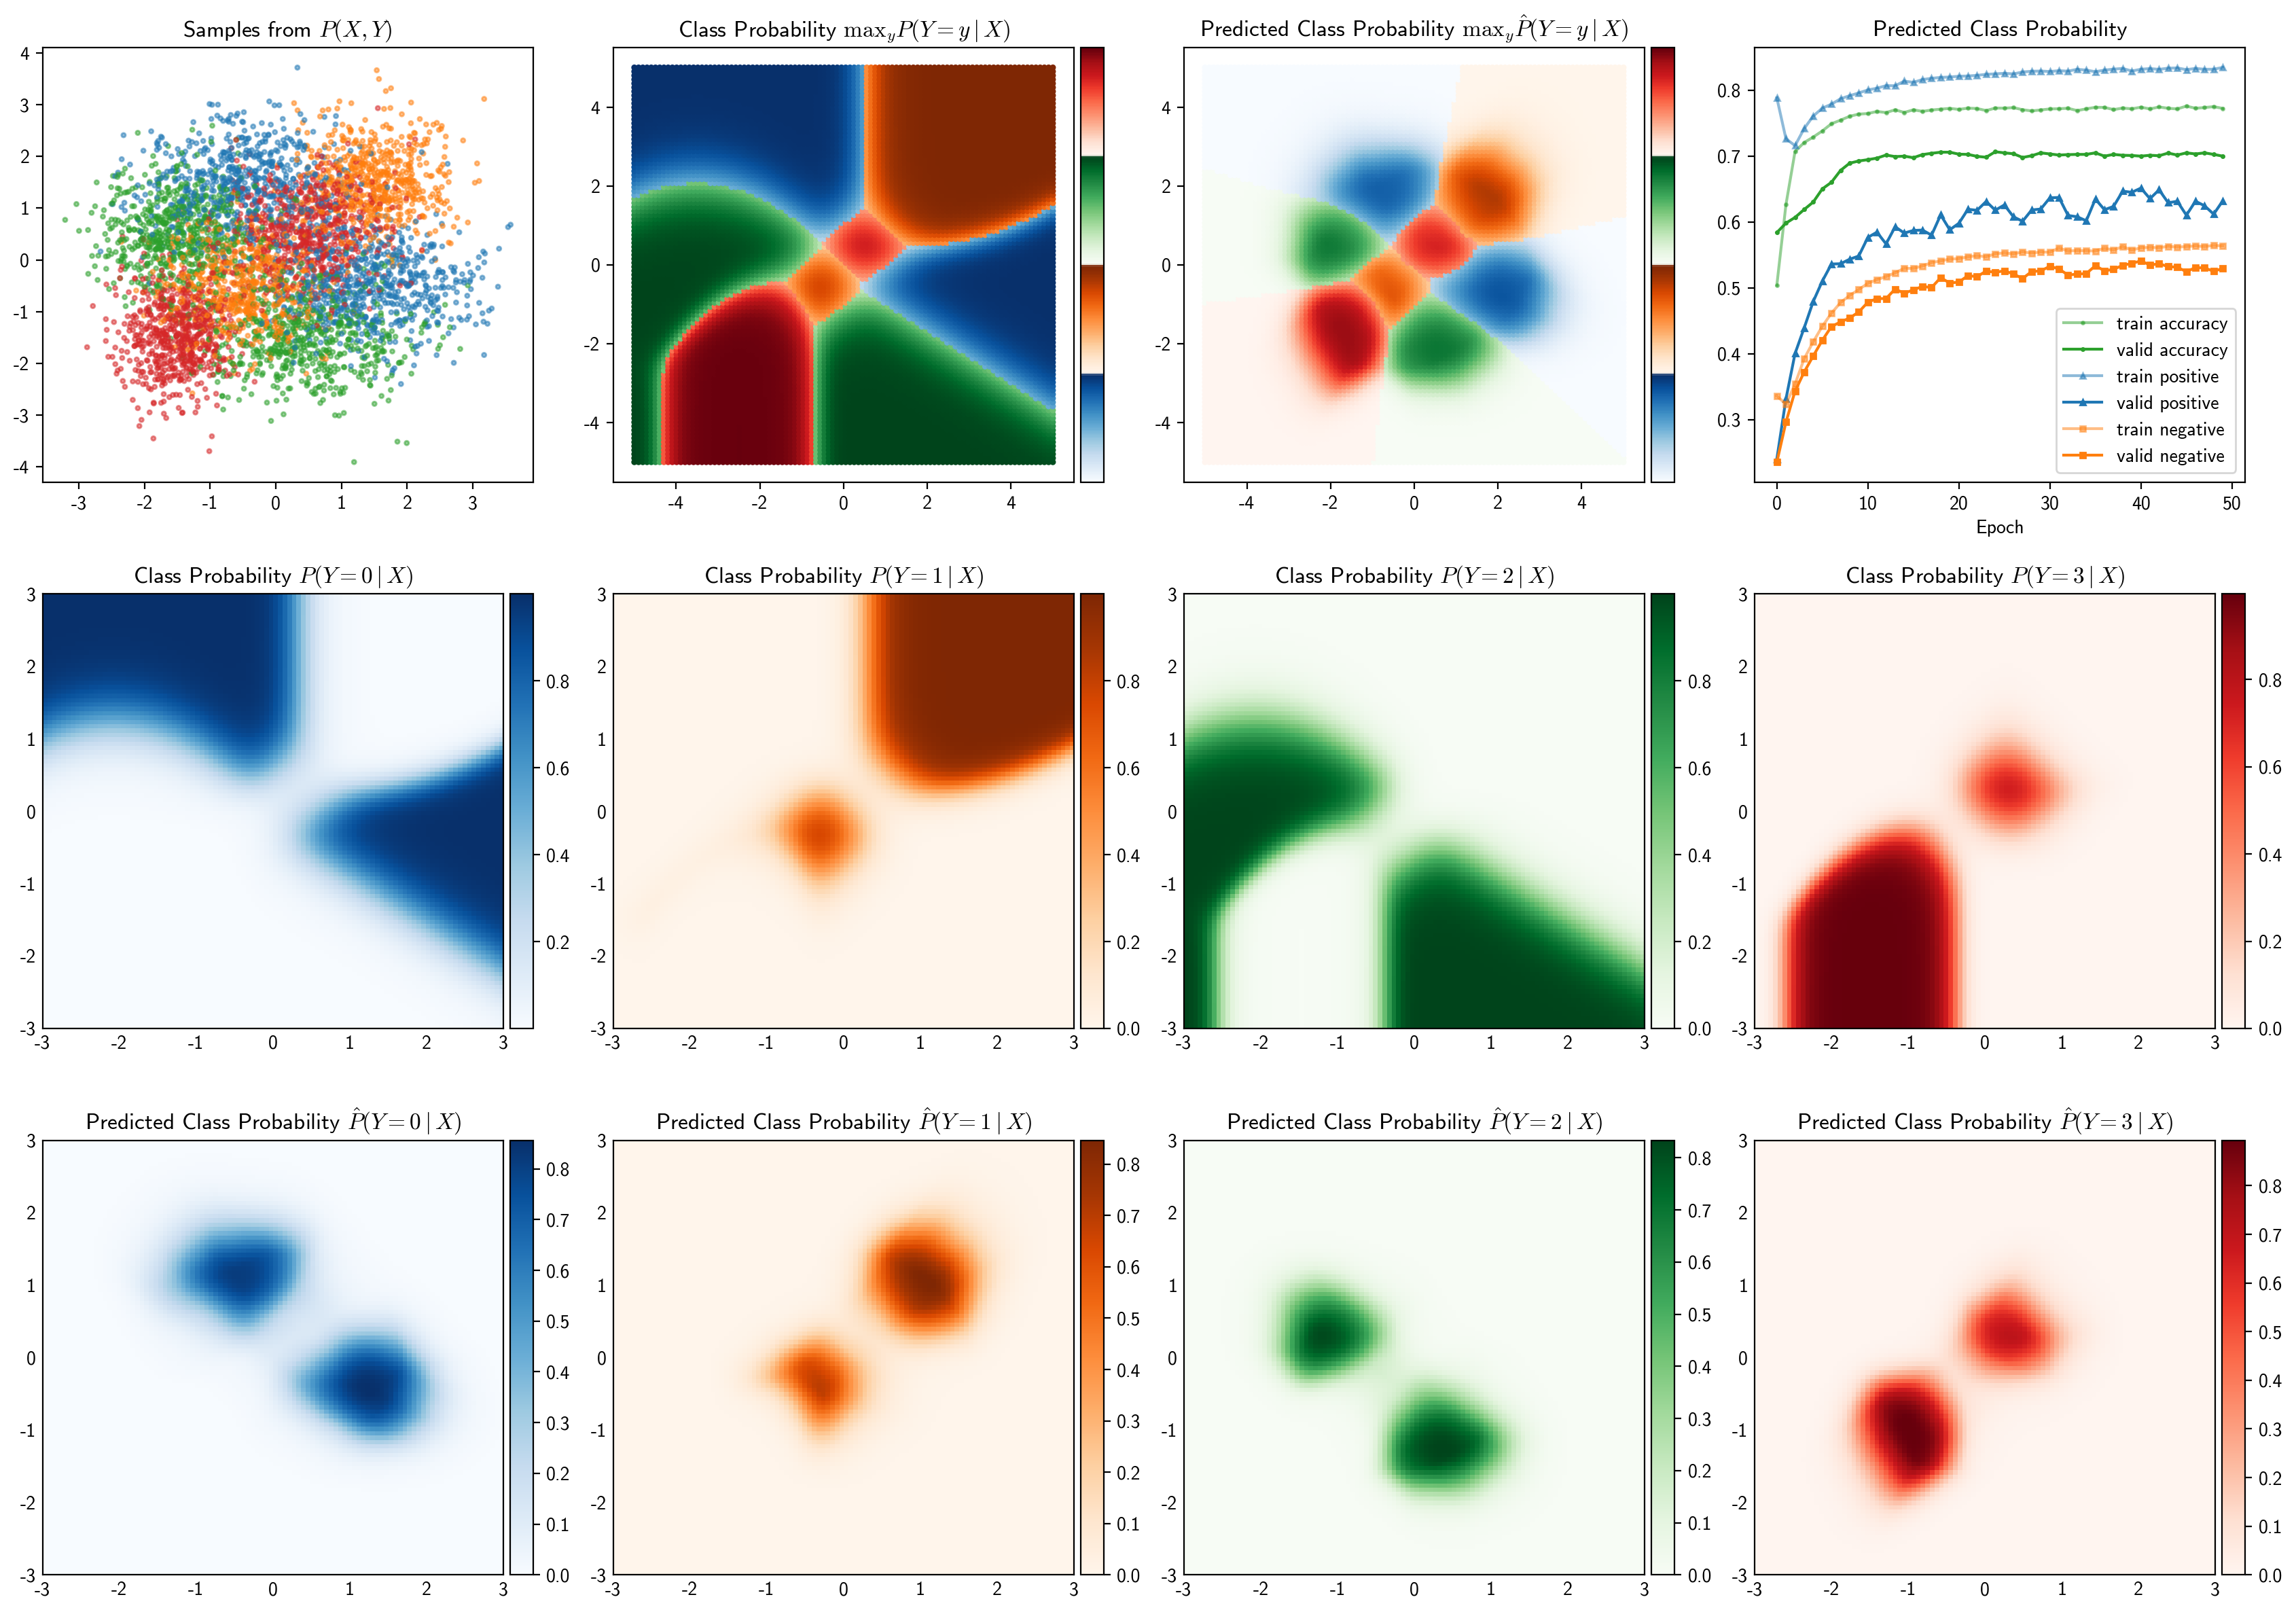

In [149]:
X, Y = torch.meshgrid(torch.linspace(-5, 5, 100), torch.linspace(-5, 5, 100))
grid = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=-1)
samples, labels = gmm.sample((5000,))

fig, axes = plt.subplots(3, 4, figsize=(17, 12))
axes[0][0].set_title('Samples from $P(X, Y)$')
img0 = axes[0][0].scatter(samples[:, 0], samples[:, 1], c=['C{}'.format(label) for label in labels], s=5, alpha=0.5)

axes[0][1].set_title(r'Class Probability $\mathrm{max}_y P(Y = y \mid X)$')
max_probs, max_labels = gmm.cond_prob(grid).max(dim=1)
colormaps = [plt.get_cmap(color) for color in ['Blues', 'Oranges', 'Greens', 'Reds']]
img1 = axes[0][1].scatter(grid[:, 0], grid[:, 1], c=[colormaps[label](prob) for prob, label in zip(max_probs, max_labels)], s=5)
cmap = mpl.colors.LinearSegmentedColormap.from_list(None, np.vstack([plt.get_cmap(color)(np.linspace(0, 1, 50)) for color in ['Blues', 'Oranges', 'Greens', 'Reds']]))
cbar = mpl.colorbar.ColorbarBase(make_axes_locatable(axes[0][1]).append_axes('right', size='5%', pad=0.05), cmap=cmap, orientation = 'vertical')
cbar.set_ticks([])

axes[0][2].set_title(r'Predicted Class Probability $\mathrm{max}_y \hat{P}(Y = y \mid X)$')
probs = F.softmax(model(grid.cuda()), dim=-1)[:, :4]
max_probs, preds = probs.max(axis=1)
axes[0][2].scatter(grid[:, 0], grid[:, 1], c=[colormaps[pred](prob) for prob, pred in zip(max_probs.detach().cpu(), preds.detach().cpu())], s=5)
cbar = mpl.colorbar.ColorbarBase(make_axes_locatable(axes[0][2]).append_axes('right', size='5%', pad=0.05), cmap=cmap, orientation = 'vertical')
cbar.set_ticks([])

axes[0][3].set_title('Predicted Class Probability')
axes[0][3].plot(range(len(std_hist['train_acc'])), std_hist['train_acc'], marker='.', c='C2', label='train accuracy', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(std_hist['valid_acc'])), std_hist['valid_acc'], marker='.', c='C2', label='valid accuracy', markersize=3)
axes[0][3].plot(range(len(std_hist['train_prob_pos'])), std_hist['train_prob_pos'], marker='^', c='C0', label='train positive', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(std_hist['valid_prob_pos'])), std_hist['valid_prob_pos'], marker='^', c='C0', label='valid positive', markersize=3)
axes[0][3].plot(range(len(std_hist['train_prob_neg'])), std_hist['train_prob_neg'], marker='s', c='C1', label='train negative', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(std_hist['valid_prob_neg'])), std_hist['valid_prob_neg'], marker='s', c='C1', label='valid negative', markersize=3)
axes[0][3].set_xlabel('Epoch')
axes[0][3].legend();

for class_idx in range(4):
    axes[1][class_idx].set_title('Class Probability $P(Y = {} \mid X)$'.format(class_idx))
    img = axes[1][class_idx].imshow(gmm.cond_prob(grid)[:, class_idx].view(100, 100).detach().cpu().numpy().transpose(), cmap=colormaps[class_idx], origin='lower', aspect='auto', extent=[-3, 3, -3, 3],)
    axes[1][class_idx].tick_params(axis='both', which='both', length=0)
    plt.colorbar(img, cax=make_axes_locatable(axes[1][class_idx]).append_axes('right', size='5%', pad=0.05), orientation='vertical')  
    
    axes[2][class_idx].set_title('Predicted Class Probability $\hat{{P}}(Y = {} \mid X)$'.format(class_idx))
    img = axes[2][class_idx].imshow(probs[:, class_idx].view(100, 100).detach().cpu().numpy().transpose(), cmap=colormaps[class_idx], origin='lower', aspect='auto', extent=[-3, 3, -3, 3],)
    axes[2][class_idx].tick_params(axis='both', which='both', length=0)
    plt.colorbar(img, cax=make_axes_locatable(axes[2][class_idx]).append_axes('right', size='5%', pad=0.05), orientation='vertical')  
plt.tight_layout()

### Evidential Deep Learning

In [19]:
class DirichletNetwork(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 4))
        self.net[-1].weight.data.zero_()
        self.net[-1].bias.data.zero_()
    
    def forward(self, x):
        return F.softplus(self.net(x))
#         return F.relu(self.net(x)) + 1e-6
    
model = DirichletNetwork().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
flat_dirichlet = D.Dirichlet(torch.tensor([1.] * 4, dtype=torch.float32, requires_grad=False).cuda())

train_loader = DataLoader(TensorDataset(*gmm.sample((10000,))), batch_size=100, shuffle=True)
valid_loader = DataLoader(TensorDataset(*gmm.sample((3000,))), batch_size=100, shuffle=True)

def mse_loss(labels, alphas, num_classes=4, anneal_epochs=50):
    alpha0 = alphas.sum(dim=-1, keepdims=True)
    means = alphas / alpha0
    targets = F.one_hot(labels, num_classes)
    loss = torch.sum((targets - means) ** 2, dim=-1).mean() + torch.sum(means * (1 - means) / (alpha0 + 1), dim=-1).mean()
    loss += min(1.0, global_idx / (anneal_epochs * len(train_loader))) * D.kl_divergence(D.Dirichlet((alphas - 1) * (1 - targets) + 1), flat_dirichlet).mean()
    return loss

def cross_entropy_loss(labels, alphas, num_classes=4, anneal_epochs=50):
    alpha0 = alphas.sum(dim=-1, keepdims=True)
    means = alphas / alpha0
    targets = F.one_hot(labels, num_classes)
    loss = (torch.digamma(alpha0) - torch.digamma(torch.index_select(alphas, -1, labels))).mean()
#     loss += min(1.0, global_idx / (anneal_epochs * len(train_loader))) * D.kl_divergence(D.Dirichlet((alphas - 1) * (1 - targets) + 1), flat_dirichlet).mean()
    return loss

def empirical_bayes_loss(labels, alphas, num_classes=4, anneal_epochs=50):
    means = alphas / alphas.sum(dim=-1, keepdims=True)
    targets = F.one_hot(labels, num_classes)
    loss1 = F.nll_loss(means.log(), labels)
#     loss2 = 1 * min(1.0, global_idx / (anneal_epochs * len(train_loader))) * D.kl_divergence(D.Dirichlet((alphas - 1) * (1 - targets) + 1), flat_dirichlet).mean()
#     loss2 = D.kl_divergence(D.Dirichlet((alphas - 1) * (1 - targets) + 1), flat_dirichlet).mean()
    loss2 = torch.tensor(0.).cuda()
    loss = loss1 + loss2
    return loss, loss1, loss2

criterion = empirical_bayes_loss
global_idx, eb_hist = 0, collections.defaultdict(list)
for epoch in range(50):
    start_time = time.time()
    model.train()
    train_loss, train_loss1, train_loss2, train_acc, train_alpha_pos, train_alpha_neg, grad_norm = 0., 0., 0., 0., 0., 0., 0.
    for batch_idx, (samples, labels) in enumerate(train_loader):
        global_idx += 1
        samples, labels = samples.cuda(), labels.cuda()
        alphas = model(samples)
        alpha0 = alphas.sum(dim=-1, keepdims=True)
#         loss = mse_loss(labels, alphas)
#         loss = cross_entropy_loss(labels, alphas)
        loss, loss1, loss2 = criterion(labels, alphas)
    
        optimizer.zero_grad()
        loss.backward()
        grad_norm += np.sqrt(sum(p.grad.data.norm() ** 2 for p in model.parameters() if p.grad is not None).detach().cpu())
        optimizer.step()
        train_loss += loss.item()
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
        mask = alphas.argmax(dim=1).eq(labels)
        train_acc += mask.sum().item()
        train_alpha_pos += alpha0[mask].sum().item()
        train_alpha_neg += alpha0[~mask].sum().item()   
        
    model.eval()
    valid_loss, valid_acc, valid_alpha_pos, valid_alpha_neg = 0., 0., 0., 0.
    for batch_idx, (samples, labels) in enumerate(valid_loader):
        samples, labels = samples.cuda(), labels.cuda()
        alphas = model(samples)
        alpha0 = alphas.sum(dim=-1, keepdims=True)
        means = alphas / alpha0
        loss = criterion(labels, alphas)
    
        mask = alphas.argmax(dim=1).eq(labels)
        valid_acc += mask.sum().item()
        valid_alpha_pos += alpha0[mask].sum().item()
        valid_alpha_neg += alpha0[~mask].sum().item()
    
    eb_hist['train_loss'].append(train_loss / len(train_loader))
    eb_hist['train_loss1'].append(train_loss1 / len(train_loader))
    eb_hist['train_loss2'].append(train_loss2 / len(train_loader))
    eb_hist['train_acc'].append(train_acc / len(train_loader.dataset))
    eb_hist['train_alpha_pos'].append(train_alpha_pos / (train_acc + 1e-6))
    eb_hist['train_alpha_neg'].append(train_alpha_neg / (len(train_loader.dataset) - train_acc))
    
    eb_hist['valid_loss'].append(valid_loss / len(valid_loader))
    eb_hist['valid_acc'].append(valid_acc / len(valid_loader.dataset))
    eb_hist['valid_alpha_pos'].append(valid_alpha_pos / (valid_acc + 1e-6))
    eb_hist['valid_alpha_neg'].append(valid_alpha_neg / (len(valid_loader.dataset) - valid_acc))
    
    print('Epoch {:02d}: train_loss {:.3f} (nll {:.3f} | reg {:.3f}), train_acc {:.3f}, train_pos {:.3f}, train_neg {:.3f}, valid_loss {:.3f}, valid_acc {:.3f}, valid_pos {:.3f}, valid_neg {:.3f}, grad_norm {:.3f}, time {:.3f}s'.format(
        epoch, eb_hist['train_loss'][-1], eb_hist['train_loss1'][-1], eb_hist['train_loss2'][-1], eb_hist['train_acc'][-1], eb_hist['train_alpha_pos'][-1], eb_hist['train_alpha_neg'][-1], eb_hist['valid_loss'][-1],
        eb_hist['valid_acc'][-1], eb_hist['valid_alpha_pos'][-1], eb_hist['valid_alpha_neg'][-1], grad_norm / len(train_loader), time.time() - start_time
    ))

Epoch 00: train_loss 1.381 (nll 1.381 | reg 0.000), train_acc 0.494, train_pos 2.772, train_neg 2.772, valid_loss 0.000, valid_acc 0.498, valid_pos 2.772, valid_neg 2.772, grad_norm 0.141, time 0.430s
Epoch 01: train_loss 1.370 (nll 1.370 | reg 0.000), train_acc 0.510, train_pos 2.770, train_neg 2.770, valid_loss 0.000, valid_acc 0.502, valid_pos 2.768, valid_neg 2.768, grad_norm 0.155, time 0.428s
Epoch 02: train_loss 1.353 (nll 1.353 | reg 0.000), train_acc 0.514, train_pos 2.765, train_neg 2.765, valid_loss 0.000, valid_acc 0.516, valid_pos 2.762, valid_neg 2.761, grad_norm 0.181, time 0.426s
Epoch 03: train_loss 1.327 (nll 1.327 | reg 0.000), train_acc 0.582, train_pos 2.758, train_neg 2.756, valid_loss 0.000, valid_acc 0.571, valid_pos 2.755, valid_neg 2.750, grad_norm 0.218, time 0.426s
Epoch 04: train_loss 1.288 (nll 1.288 | reg 0.000), train_acc 0.591, train_pos 2.751, train_neg 2.743, valid_loss 0.000, valid_acc 0.597, valid_pos 2.750, valid_neg 2.734, grad_norm 0.257, time 0.

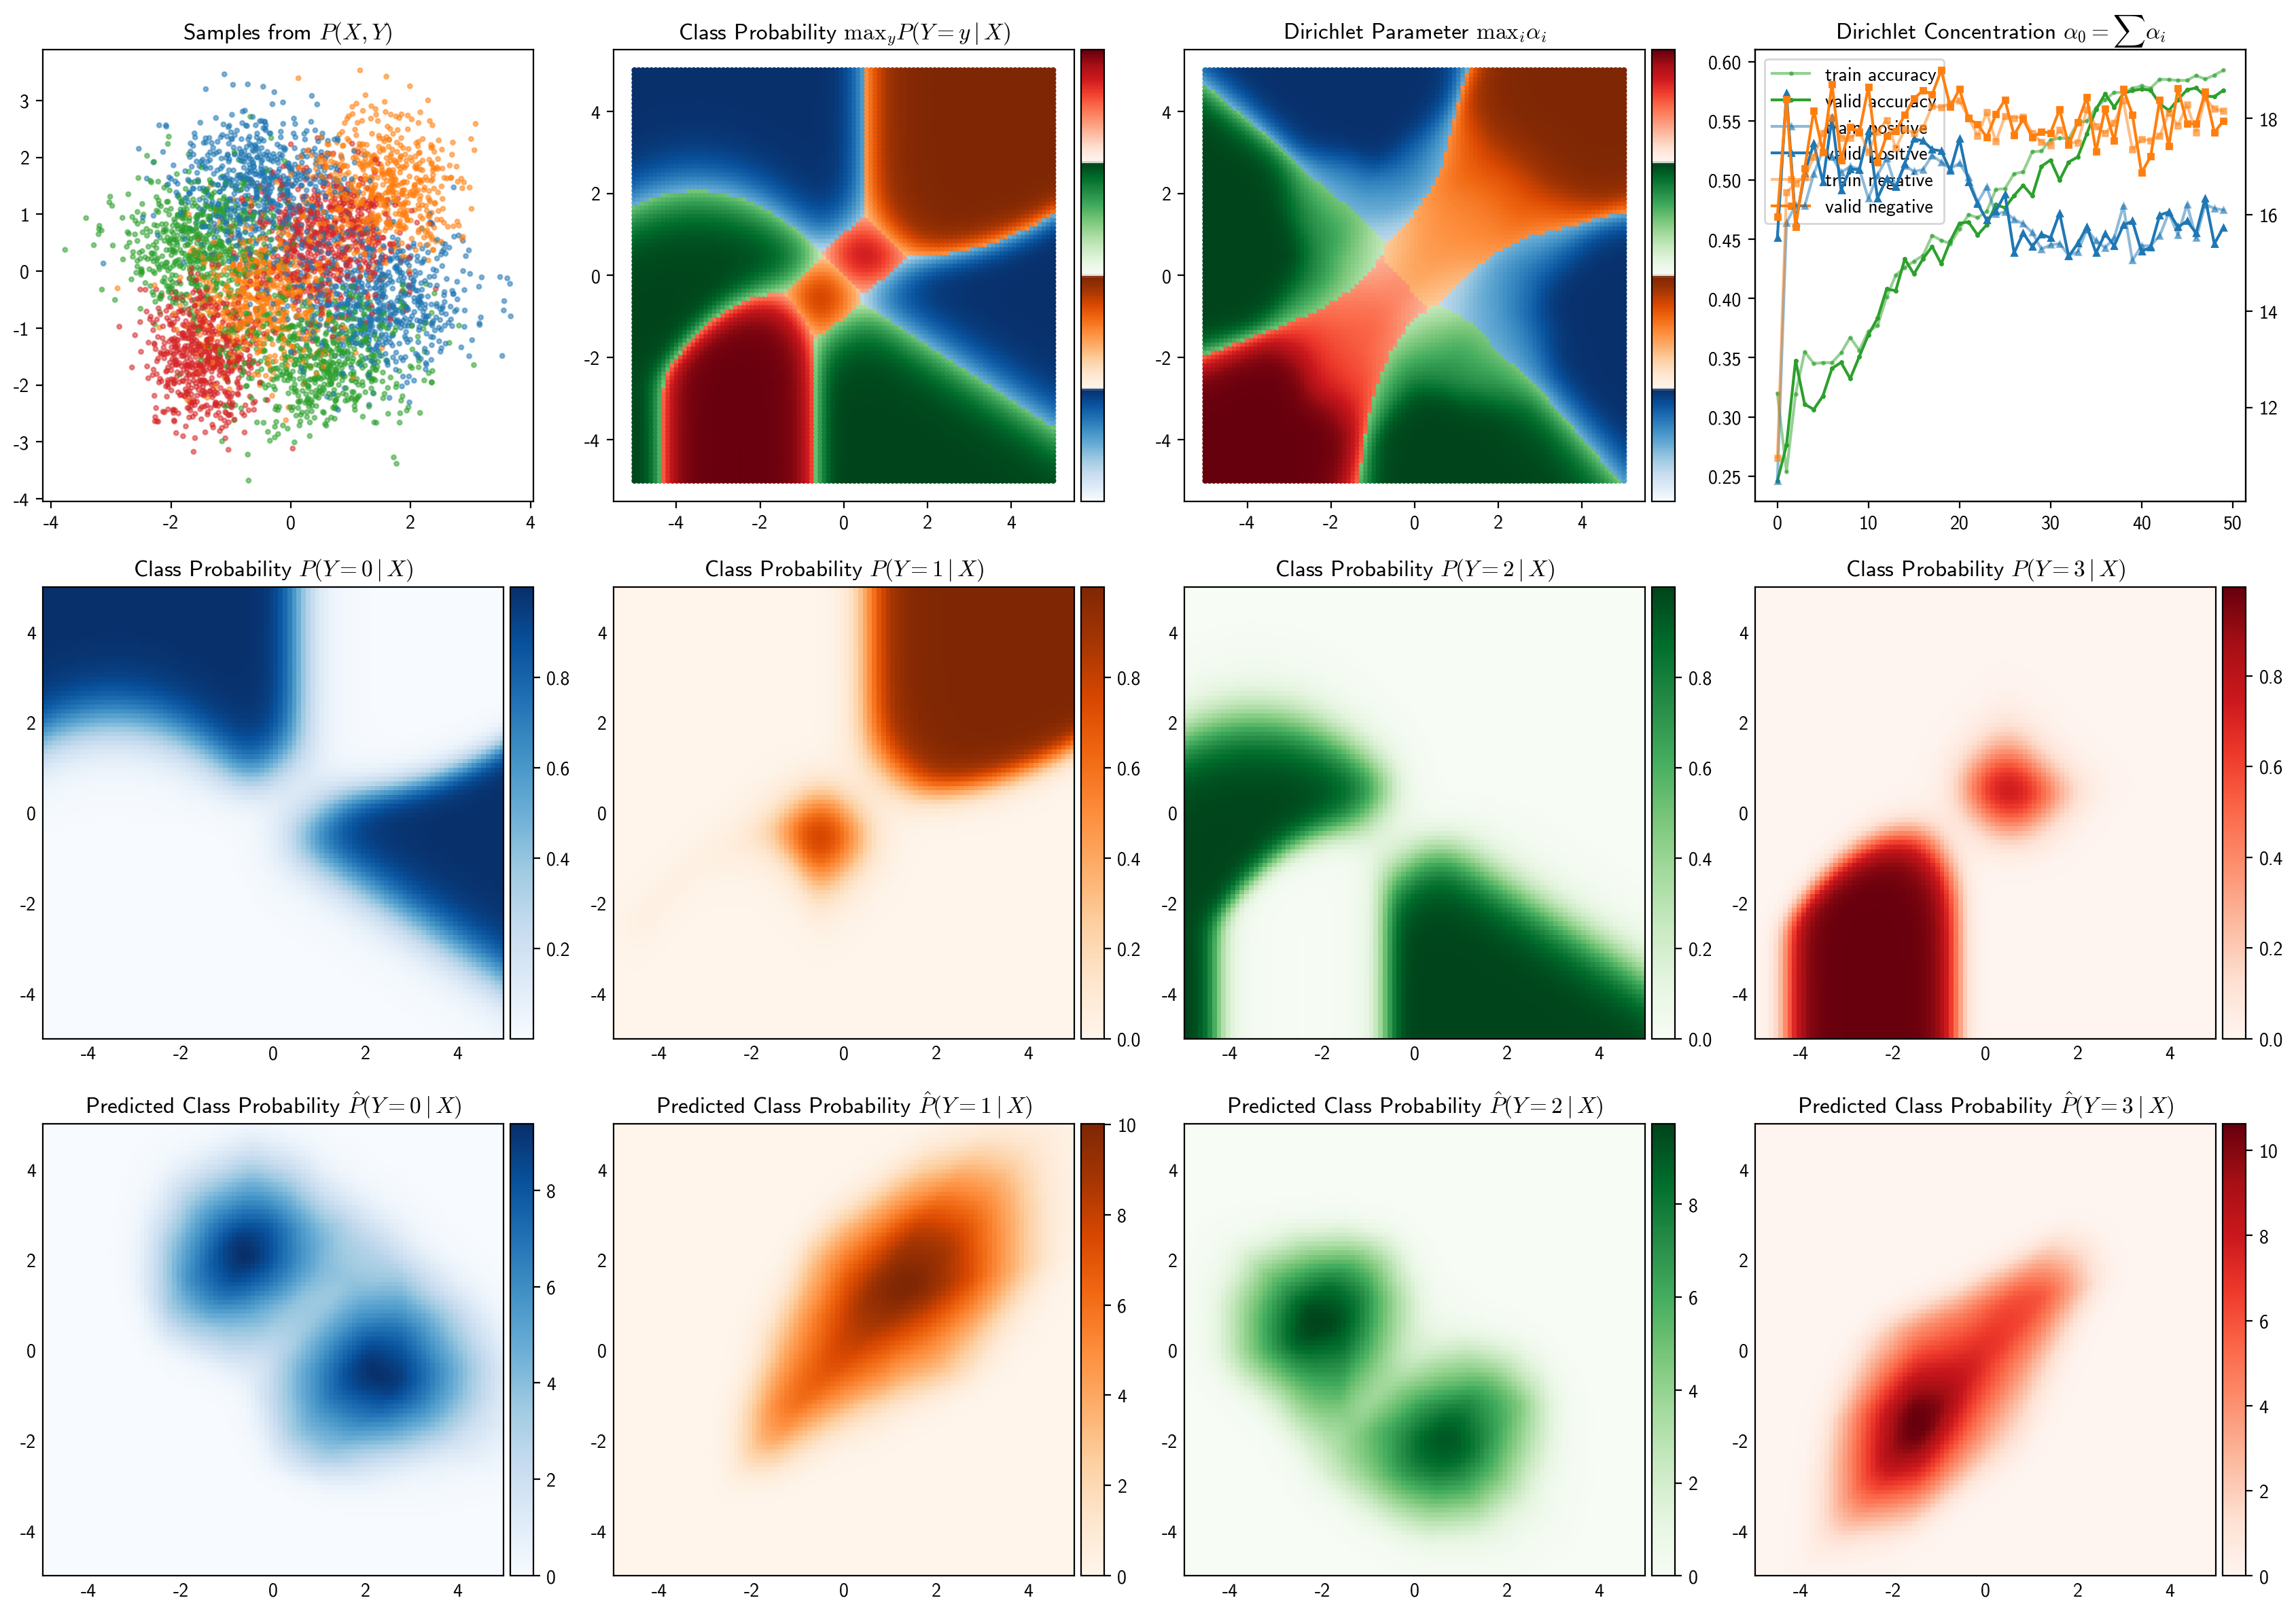

In [24]:
X, Y = torch.meshgrid(torch.linspace(-5, 5, 100), torch.linspace(-5, 5, 100))
grid = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=-1)
samples, labels = gmm.sample((5000,))

fig, axes = plt.subplots(3, 4, figsize=(17, 12))
axes[0][0].set_title('Samples from $P(X, Y)$')
img0 = axes[0][0].scatter(samples[:, 0], samples[:, 1], c=['C{}'.format(label) for label in labels], s=5, alpha=0.5)

axes[0][1].set_title(r'Class Probability $\mathrm{max}_y P(Y = y \mid X)$')
max_probs, max_labels = gmm.cond_prob(grid).max(dim=1)
colormaps = [plt.get_cmap(color) for color in ['Blues', 'Oranges', 'Greens', 'Reds']]
img1 = axes[0][1].scatter(grid[:, 0], grid[:, 1], c=[colormaps[label](prob) for prob, label in zip(max_probs, max_labels)], s=5)
cmap = mpl.colors.LinearSegmentedColormap.from_list(None, np.vstack([plt.get_cmap(color)(np.linspace(0, 1, 50)) for color in ['Blues', 'Oranges', 'Greens', 'Reds']]))
cbar = mpl.colorbar.ColorbarBase(make_axes_locatable(axes[0][1]).append_axes('right', size='5%', pad=0.05), cmap=cmap, orientation = 'vertical')
cbar.set_ticks([])

axes[0][2].set_title('Dirichlet Parameter $\mathrm{max}_i \\alpha_i$')
alphas = model(grid.cuda())
probs = alphas / alphas.sum(dim=-1, keepdims=True)
max_probs, preds = probs.max(axis=1)
axes[0][2].scatter(grid[:, 0], grid[:, 1], c=[colormaps[pred](prob) for prob, pred in zip(max_probs.detach().cpu(), preds.detach().cpu())], s=5)
cbar = mpl.colorbar.ColorbarBase(make_axes_locatable(axes[0][2]).append_axes('right', size='5%', pad=0.05), cmap=cmap, orientation = 'vertical')
cbar.set_ticks([])

axes[0][3].set_title('Dirichlet Concentration $\\alpha_0 = \sum \\alpha_i$')
axes[0][3].plot(range(len(eb_hist['train_acc'])), eb_hist['train_acc'], marker='.', c='C2', label='train accuracy', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(eb_hist['valid_acc'])), eb_hist['valid_acc'], marker='.', c='C2', label='valid accuracy', markersize=3)
cax = axes[0][3].twinx()
cax.plot(range(len(eb_hist['train_alpha_pos'])), np.array(eb_hist['train_alpha_pos']), marker='^', c='C0', label='train positive', markersize=3, alpha=0.5)
cax.plot(range(len(eb_hist['valid_alpha_pos'])), np.array(eb_hist['valid_alpha_pos']), marker='^', c='C0', label='valid positive', markersize=3)
cax.plot(range(len(eb_hist['train_alpha_neg'])), np.array(eb_hist['train_alpha_neg']), marker='s', c='C1', label='train negative', markersize=3, alpha=0.5)
cax.plot(range(len(eb_hist['valid_alpha_neg'])), np.array(eb_hist['valid_alpha_neg']), marker='s', c='C1', label='valid negative', markersize=3)
cax.set_xlabel('Epoch')
lines, labels = axes[0][3].get_legend_handles_labels()
lines2, labels2 = cax.get_legend_handles_labels()
axes[0][3].legend(lines + lines2, labels + labels2, loc=0)

for class_idx in range(4):
    axes[1][class_idx].set_title('Class Probability $P(Y = {} \mid X)$'.format(class_idx))
    img = axes[1][class_idx].imshow(gmm.cond_prob(grid)[:, class_idx].view(100, 100).detach().cpu().numpy().transpose(), cmap=colormaps[class_idx], origin='lower', aspect='auto', extent=[-5, 5, -5, 5],)
    axes[1][class_idx].tick_params(axis='both', which='both', length=0)
    plt.colorbar(img, cax=make_axes_locatable(axes[1][class_idx]).append_axes('right', size='5%', pad=0.05), orientation='vertical')  
    
    axes[2][class_idx].set_title('Predicted Class Probability $\hat{{P}}(Y = {} \mid X)$'.format(class_idx))
    img = axes[2][class_idx].imshow(alphas[:, class_idx].view(100, 100).detach().cpu().numpy().transpose(), cmap=colormaps[class_idx], origin='lower', aspect='auto', extent=[-5, 5, -5, 5],)
    axes[2][class_idx].tick_params(axis='both', which='both', length=0)
    plt.colorbar(img, cax=make_axes_locatable(axes[2][class_idx]).append_axes('right', size='5%', pad=0.05), orientation='vertical')  
plt.tight_layout()

### Bayesian Neural Networks

In [9]:
class BayesParameter(nn.Module):
    def __init__(self, shape, rho_prior=[0., -6.]):
        super().__init__()
        self.sigma_prior = [torch.tensor(rho).exp() for rho in rho_prior]
        self.mu = nn.Parameter(torch.Tensor(*shape).uniform_(-0.2, 0.2))
        self.rho = nn.Parameter(torch.zeros(*shape).uniform_(-5., -4.))

    def sample(self):
        def log_gaussian(x, mu, sigma):
            return -0.5 * np.log(2 * np.pi) - sigma.log() - (x - mu) ** 2 / (2 * sigma ** 2)
    
        def log_mixture_gaussians(x, mus, sigmas, ratios):
            prob = torch.zeros_like(x)
            for mu, sigma, ratio in zip(mus, sigmas, ratios):
                prob += float(ratio) * log_gaussian(x, mu, sigma).exp()
            return torch.log(prob)
        
        epsilon = torch.randn_like(self.mu)
        sigma = F.softplus(self.rho)
        weight = self.mu + sigma * epsilon
        log_prior = log_mixture_gaussians(weight, mus=[0., 0.], sigmas=self.sigma_prior, ratios=[0.5, 0.5]).sum()
        log_posterior = log_gaussian(weight, self.mu, sigma).sum()
        return weight, log_prior, log_posterior


class DenseLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = BayesParameter((in_features, out_features))
        self.bias = BayesParameter((out_features,))
        self.log_prior = 0
        self.log_posterior = 0

    def forward(self, input, inference=False):
        if inference:
            return torch.mm(input, self.weight.mu) + self.bias.mu

        weight, log_prior_weight, log_posterior_weight = self.weight.sample()
        bias, log_prior_bias, log_posterior_bias = self.bias.sample()
        output = torch.mm(input, weight) + bias

        self.log_prior = log_prior_weight + log_prior_bias
        self.log_posterior = log_posterior_weight + log_posterior_bias
        return output
    

class BayesNet(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.fc1 = DenseLayer(2, hidden_dim)
        self.fc2 = DenseLayer(hidden_dim, hidden_dim)
        self.fc3 = DenseLayer(hidden_dim, 4)

    def forward(self, x, inference=False):
        x = F.relu(self.fc1(x.view(x.size()[0], -1), inference))
        x = F.relu(self.fc2(x, inference))
        x = self.fc3(x, inference)
        return x

    def log_prior(self):
        return self.fc1.log_prior + self.fc2.log_prior + self.fc3.log_prior

    def log_posterior(self):
        return self.fc1.log_posterior + self.fc2.log_posterior + self.fc3.log_posterior

    
model = BayesNet().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
train_loader = DataLoader(TensorDataset(*gmm.sample((3000,))), batch_size=100, shuffle=True)
valid_loader = DataLoader(TensorDataset(*gmm.sample((3000,))), batch_size=100, shuffle=True)

model.train()
bbb_hist = collections.defaultdict(list)
for epoch in range(50):
    model.train()
    train_loss, train_nll, train_bayes, train_acc, train_prob_pos, train_prob_neg = 0., 0., 0., 0., 0., 0.
    for batch_idx, (samples, labels) in enumerate(train_loader):
        samples, labels = samples.cuda(), labels.cuda()
        logits = model(samples)
        nll_loss = F.cross_entropy(logits, labels, reduction='sum')
        bayes_loss =  (model.log_posterior() - model.log_prior()) / len(train_loader)
        loss = nll_loss + bayes_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_nll += nll_loss.item()
        train_bayes += bayes_loss.item()

        preds = logits.argmax(dim=1)
        mask = preds.eq(labels)
        train_acc += mask.sum().item()
        max_probs = torch.gather(F.softmax(logits, dim=-1), dim=-1, index=preds.unsqueeze(-1))
        train_prob_pos += max_probs[mask].sum().item()
        train_prob_neg += max_probs[~mask].sum().item()
        
    model.eval()
    valid_loss, valid_acc, valid_prob_pos, valid_prob_neg = 0., 0., 0., 0.
    for batch_idx, (samples, labels) in enumerate(valid_loader):
        samples, labels = samples.cuda(), labels.cuda()
        logits = model(samples, inference=True)
        loss = F.cross_entropy(logits, labels, reduction='sum')
        valid_loss += loss.item()
        
        preds = logits.argmax(dim=1)
        mask = preds.eq(labels)
        valid_acc += mask.sum().item()
        max_probs = torch.gather(F.softmax(logits, dim=-1), dim=-1, index=preds.unsqueeze(-1))
        valid_prob_pos += max_probs[mask].sum().item()
        valid_prob_neg += max_probs[~mask].sum().item()
        
    bbb_hist['train_loss'].append(train_loss / len(train_loader))
    bbb_hist['train_nll'].append(train_nll / len(train_loader))
    bbb_hist['train_bayes'].append(train_bayes / len(train_loader))
    bbb_hist['train_acc'].append(train_acc / len(train_loader.dataset))
    bbb_hist['train_prob_pos'].append(train_prob_pos / (train_acc + 1e-6))
    bbb_hist['train_prob_neg'].append(train_prob_neg / (len(train_loader.dataset) - train_acc))
    
    bbb_hist['valid_loss'].append(valid_loss / len(valid_loader))
    bbb_hist['valid_acc'].append(valid_acc / len(valid_loader.dataset))
    bbb_hist['valid_prob_pos'].append(valid_prob_pos / (valid_acc + 1e-6))
    bbb_hist['valid_prob_neg'].append(valid_prob_neg / (len(valid_loader.dataset) - valid_acc))
        
    print('Epoch {:02d}: train_loss {:.3f} (nll {:.3f} | bayes {:.3f}), train_acc {:.3f}, train_pos {:.3f}, train_neg {:.3f}, valid_loss {:.3f}, valid_acc {:.3f}, valid_pos {:.3f}, valid_neg {:.3f}'.format(
        epoch, bbb_hist['train_loss'][-1], bbb_hist['train_nll'][-1], bbb_hist['train_bayes'][-1], bbb_hist['train_acc'][-1], bbb_hist['train_prob_pos'][-1], bbb_hist['train_prob_neg'][-1], bbb_hist['valid_loss'][-1], bbb_hist['valid_acc'][-1],
        bbb_hist['valid_prob_pos'][-1], bbb_hist['valid_prob_neg'][-1],
    ))

Epoch 00: train_loss 2824.305 (nll 105.720 | bayes 2718.585), train_acc 0.536, train_pos 0.647, train_neg 0.506, valid_loss 112.339, valid_acc 0.497, valid_pos 0.746, valid_neg 0.592
Epoch 01: train_loss 2813.779 (nll 87.368 | bayes 2726.411), train_acc 0.643, train_pos 0.711, train_neg 0.571, valid_loss 93.055, valid_acc 0.615, valid_pos 0.712, valid_neg 0.570
Epoch 02: train_loss 2804.344 (nll 83.986 | bayes 2720.357), train_acc 0.667, train_pos 0.716, train_neg 0.577, valid_loss 81.265, valid_acc 0.685, valid_pos 0.753, valid_neg 0.611
Epoch 03: train_loss 2796.152 (nll 81.041 | bayes 2715.111), train_acc 0.678, train_pos 0.727, train_neg 0.597, valid_loss 81.169, valid_acc 0.671, valid_pos 0.726, valid_neg 0.584
Epoch 04: train_loss 2789.559 (nll 79.776 | bayes 2709.782), train_acc 0.686, train_pos 0.731, train_neg 0.597, valid_loss 78.238, valid_acc 0.685, valid_pos 0.710, valid_neg 0.571
Epoch 05: train_loss 2785.419 (nll 81.189 | bayes 2704.229), train_acc 0.673, train_pos 0.726

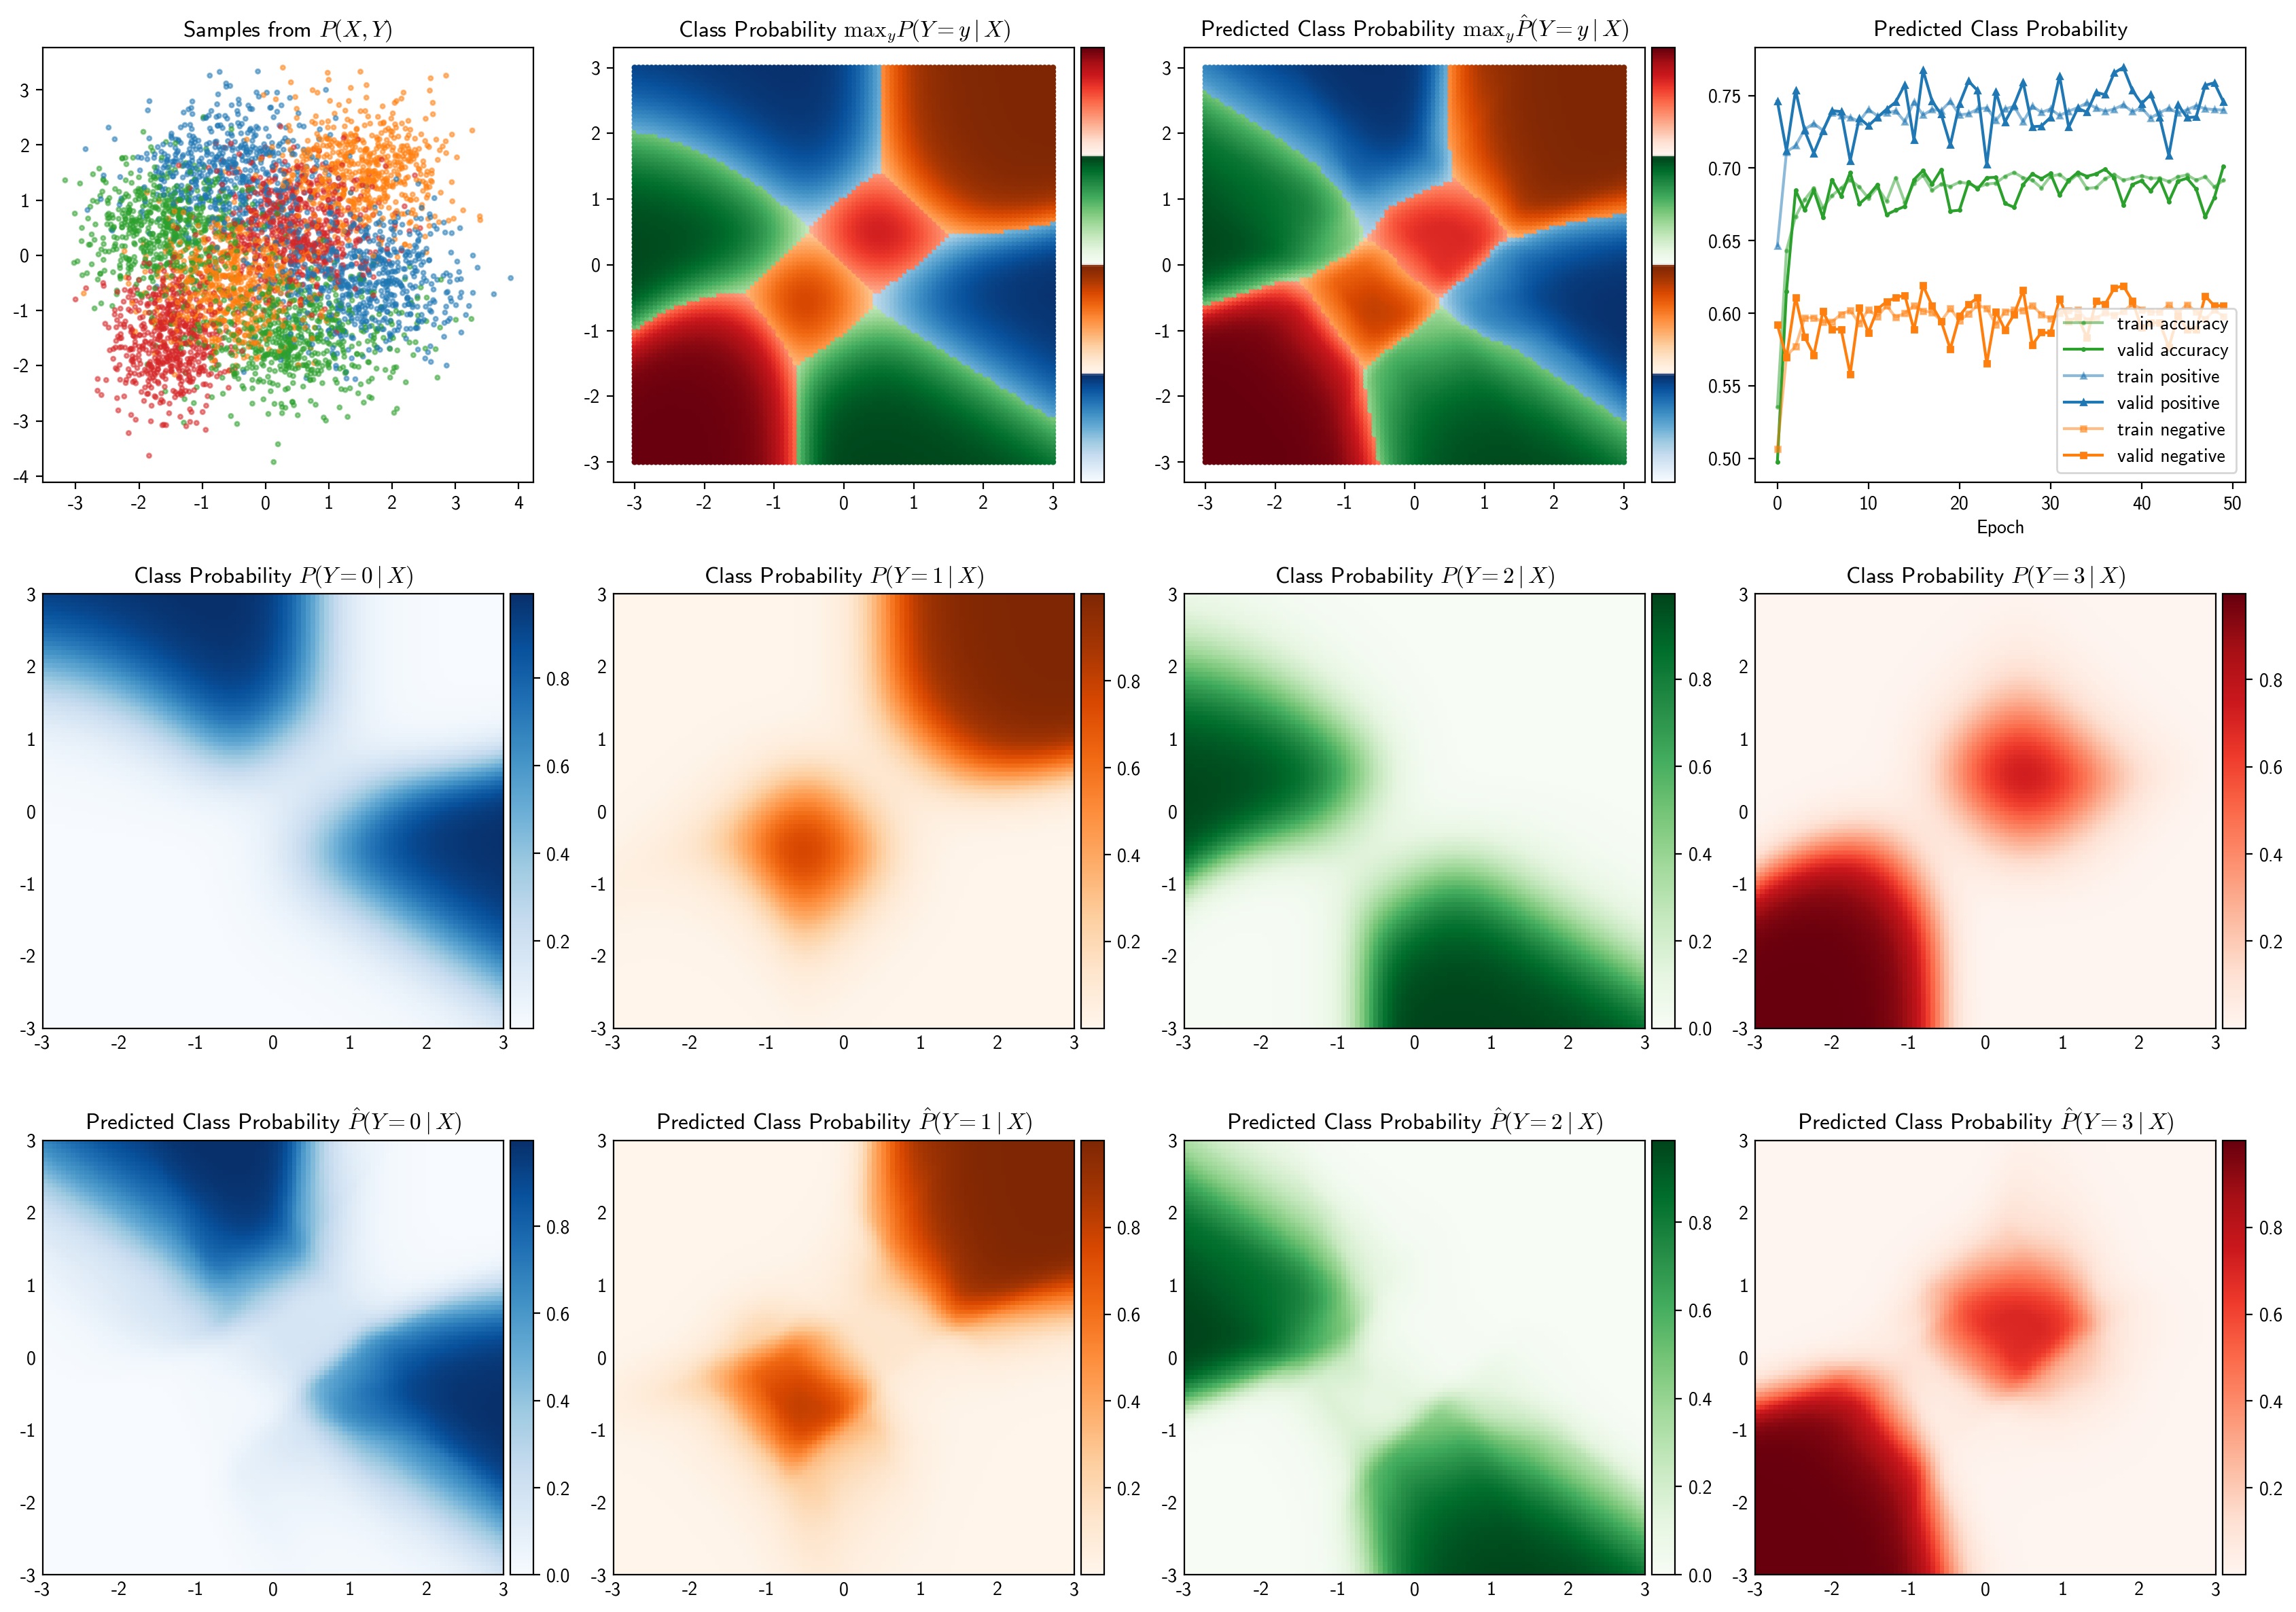

In [11]:
X, Y = torch.meshgrid(torch.linspace(-3, 3, 100), torch.linspace(-3, 3, 100))
grid = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=-1)
samples, labels = gmm.sample((5000,))

fig, axes = plt.subplots(3, 4, figsize=(17, 12))
axes[0][0].set_title('Samples from $P(X, Y)$')
img0 = axes[0][0].scatter(samples[:, 0], samples[:, 1], c=['C{}'.format(label) for label in labels], s=5, alpha=0.5)

axes[0][1].set_title(r'Class Probability $\mathrm{max}_y P(Y = y \mid X)$')
max_probs, max_labels = gmm.cond_prob(grid).max(dim=1)
colormaps = [plt.get_cmap(color) for color in ['Blues', 'Oranges', 'Greens', 'Reds']]
img1 = axes[0][1].scatter(grid[:, 0], grid[:, 1], c=[colormaps[label](prob) for prob, label in zip(max_probs, max_labels)], s=5)
cmap = mpl.colors.LinearSegmentedColormap.from_list(None, np.vstack([plt.get_cmap(color)(np.linspace(0, 1, 50)) for color in ['Blues', 'Oranges', 'Greens', 'Reds']]))
cbar = mpl.colorbar.ColorbarBase(make_axes_locatable(axes[0][1]).append_axes('right', size='5%', pad=0.05), cmap=cmap, orientation = 'vertical')
cbar.set_ticks([])

axes[0][2].set_title(r'Predicted Class Probability $\mathrm{max}_y \hat{P}(Y = y \mid X)$')
probs = F.softmax(model(grid.cuda(), inference=True), dim=-1)
max_probs, preds = probs.max(axis=1)
axes[0][2].scatter(grid[:, 0], grid[:, 1], c=[colormaps[pred](prob) for prob, pred in zip(max_probs.detach().cpu(), preds.detach().cpu())], s=5)
cbar = mpl.colorbar.ColorbarBase(make_axes_locatable(axes[0][2]).append_axes('right', size='5%', pad=0.05), cmap=cmap, orientation = 'vertical')
cbar.set_ticks([])

axes[0][3].set_title('Predicted Class Probability')
axes[0][3].plot(range(len(bbb_hist['train_acc'])), bbb_hist['train_acc'], marker='.', c='C2', label='train accuracy', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(bbb_hist['valid_acc'])), bbb_hist['valid_acc'], marker='.', c='C2', label='valid accuracy', markersize=3)
axes[0][3].plot(range(len(bbb_hist['train_prob_pos'])), bbb_hist['train_prob_pos'], marker='^', c='C0', label='train positive', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(bbb_hist['valid_prob_pos'])), bbb_hist['valid_prob_pos'], marker='^', c='C0', label='valid positive', markersize=3)
axes[0][3].plot(range(len(bbb_hist['train_prob_neg'])), bbb_hist['train_prob_neg'], marker='s', c='C1', label='train negative', markersize=3, alpha=0.5)
axes[0][3].plot(range(len(bbb_hist['valid_prob_neg'])), bbb_hist['valid_prob_neg'], marker='s', c='C1', label='valid negative', markersize=3)
axes[0][3].set_xlabel('Epoch')
axes[0][3].legend();

for class_idx in range(4):
    axes[1][class_idx].set_title('Class Probability $P(Y = {} \mid X)$'.format(class_idx))
    img = axes[1][class_idx].imshow(gmm.cond_prob(grid)[:, class_idx].view(100, 100).detach().cpu().numpy().transpose(), cmap=colormaps[class_idx], origin='lower', aspect='auto', extent=[-3, 3, -3, 3],)
    axes[1][class_idx].tick_params(axis='both', which='both', length=0)
    plt.colorbar(img, cax=make_axes_locatable(axes[1][class_idx]).append_axes('right', size='5%', pad=0.05), orientation='vertical')  
    
    axes[2][class_idx].set_title('Predicted Class Probability $\hat{{P}}(Y = {} \mid X)$'.format(class_idx))
    img = axes[2][class_idx].imshow(probs[:, class_idx].view(100, 100).detach().cpu().numpy().transpose(), cmap=colormaps[class_idx], origin='lower', aspect='auto', extent=[-3, 3, -3, 3],)
    axes[2][class_idx].tick_params(axis='both', which='both', length=0)
    plt.colorbar(img, cax=make_axes_locatable(axes[2][class_idx]).append_axes('right', size='5%', pad=0.05), orientation='vertical')  
plt.tight_layout()

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())